# Notebook 2: Application d'analyse immobilière
---

**Projet développé par :**
- Ashley OHNONA
- Harisoa RANDRIANASOLO
- Fairouz YOUDARENE
- Jennifer ZAHORA

**Date :** 3/11/2025

---

## Présentation du projet
### Persona ciblé

#### Profil
- **Nom**: Marie
- **Age**: 40 ans
- **Occupation**: cadre supérieur à Paris

- **Budget**: 400-600k€

- **Objectif**: Acheter son premier bien locatif pour générer des revenus passifs

#### Besoins spécifiques
1. Avoir un aperçu clair du marché (prix au m2,tendances) (dashboard)
2. Identifier les villes avec le meilleur rendement locatif dans IDF
3. Comprendre quels types de biens sont les plus rentables (par département, par commune)
4. Comparer le potentiel de location simple vs coloc
5. Évaluer la liquidité du marché
6. Analyser des accessibilité des transports en commun (par département, par commune)
7. Vérifier la sécurité et l’attractivité du quartier
8. Trouver des biens accessibles avec son budget (par département, par commune)
9. Obtenir un classement des Top 10 opportunités actuelles (un tableau ou score automatique). 

---

## Objectifs de l'application
Identifier des territoires prometteurs pour un premier investissement locatif

---

## Sources de données
- DVF2024 : Demandes de valeurs foncières géolocalisées, [source](https://www.data.gouv.fr/datasets/demandes-de-valeurs-foncieres-geolocalisees/)
    - [full_2024.csv](https://files.data.gouv.fr/geo-dvf/latest/csv/2024/full.csv.gz)

- INSEE : Base officielle des communes françaises (INSEE / data.gouv.fr), [source](https://www.data.gouv.fr/datasets/communes-de-france-base-des-codes-postaux/)
    - [20230823-communes-departement-region.csv](https://www.data.gouv.fr/api/1/datasets/r/dbe8a621-a9c4-4bc3-9cae-be1699c5ff25)

- Transport : Île-de-France Mobilités — base officielle des points d’arrêt du réseau régional, [source](https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf/export/)
    - [emplacement-des-gares-idf.csv](https://data.iledefrance-mobilites.fr/api/explore/v2.1/catalog/datasets/emplacement-des-gares-idf/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B)

- Données Loyers : "Carte des loyers" - Indicateurs de loyers d'annonce par commune en 2024, [source](https://www.data.gouv.fr/datasets/carte-des-loyers-indicateurs-de-loyers-dannonce-par-commune-en-2024/)
    - [Loyer appartement](https://static.data.gouv.fr/resources/carte-des-loyers-indicateurs-de-loyers-dannonce-par-commune-en-2024/20241205-153050/pred-app-mef-dhup.csv)
    - [Loyer appartement T1-T2](https://static.data.gouv.fr/resources/carte-des-loyers-indicateurs-de-loyers-dannonce-par-commune-en-2024/20241205-153048/pred-app12-mef-dhup.csv)
    - [Loyer appartement T3+](https://static.data.gouv.fr/resources/carte-des-loyers-indicateurs-de-loyers-dannonce-par-commune-en-2024/20241205-145658/pred-app3-mef-dhup.csv)
    - [Loyer maison](https://static.data.gouv.fr/resources/carte-des-loyers-indicateurs-de-loyers-dannonce-par-commune-en-2024/20241205-145700/pred-mai-mef-dhup.csv)

- Données sécurité : Bases statistiques communale, départementale et régionale de la délinquance enregistrée par la police et la gendarmerie nationales, [source](https://www.data.gouv.fr/datasets/bases-statistiques-communale-departementale-et-regionale-de-la-delinquance-enregistree-par-la-police-et-la-gendarmerie-nationales)
    - [nom fichier](lien)

- Données activité : Dénombrement des équipements (commerce, sport, services, santé…), [source](https://catalogue-donnees.insee.fr/fr/catalogue/recherche/DS_BPE)
    - pas de lien direct
    - instructions de téléchargement

---

## Import des bibliothèques

In [3]:

# Manipulation et analyse de données
import pandas as pd
import numpy as np
import geopandas as gpd

# Visualisation statique
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation interactive
import plotly.express as px
import plotly.graph_objects as go

# Widgets et interactivité Jupyter
import ipywidgets as widgets
from ipywidgets import Output, interact, Dropdown, IntSlider
from IPython.display import display, clear_output, HTML

# Cartographie interactive
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm

# Géométrie (utile pour GeoDataFrames)
from shapely.geometry import Point

---

### Chargement des données

In [4]:
# --- Chargement des données nettoyées (préparées dans le Notebook 1) ---
# DVF
dvf_df = pd.read_csv('data/cleaned/dvf_idf_clean.csv')
# dvf_df["valeur_fonciere"] = pd.to_numeric(dvf_df["valeur_fonciere"], errors="coerce") ## valeur_fonciere deja num

# Communes
# communes_df = pd.read_csv('data/cleaned/communes.csv')

# Indicateurs de loyer
loyers_df = pd.read_csv('data/cleaned/loyers_IDF_2024.csv')  ## already with latitude and longitude data
# loyer_predit deja num

# Transports
communes_gdf = gpd.read_file("data/cleaned/communes_coordonnees.geojson")
transports_gdf = gpd.read_file("data/cleaned/transports_nettoyes.geojson")


### Widget 1 :  Avoir un aperçu clair du marché (prix au m2,tendances) (dashboard)
- Widget  à part par ce que elle est faite sur streamlit

### **Widget 2 : Identifier les villes avec le meilleur rendement locatif dans IDF**

**Objectif rincipal**

Identifier les villes avec le meilleur rendement locatif en Île-de-France
Cette analyse permet de repérer les communes offrant les opportunités d'investissement immobilier les plus rentables en comparant les prix de vente avec les loyers estimés.


In [ ]:
# Création du df_rendement_brut
# ============================================================
def categorise_type_bien(row):
    """Helper function to categorise properties in dvf, according to how they are categorised for rent"""
    if row['type_local'] == 'Maison':
        return 'Maison'
    elif row['type_local'] == 'Appartement':
        if pd.isna(row['nombre_pieces_principales']) or row['nombre_pieces_principales'] == 0:
            return 'Appartement'
        elif row['nombre_pieces_principales'] <= 2:
            return 'Appartement T1-T2'
        elif row['nombre_pieces_principales'] >= 3:
            return 'Appartement T3+'
    return row['type_local']  # Fallback to original type if no condition matches

def merge_datasets(df1, df2, left="INSEE_COM", right="code_commune", on=None):
    """Fusion sur les codes INSEE"""
    if on is not None:
        df = df2.merge(df1, on=on, how="inner")
    else:
        df = df2.merge(df1, left_on=left, right_on=right, how="inner")
    return df

def merge_nom_commune_columns(df):
    """Merge nom_commune_x and nom_commune_y columns, keeping non-null values"""
    if 'nom_commune_x' in df.columns and 'nom_commune_y' in df.columns:
        df['nom_commune'] = df['nom_commune_x'].fillna(df['nom_commune_y'])
        df = df.drop(columns=['nom_commune_x', 'nom_commune_y'])
    return df

def create_dvf_rent_dataset(dvf_df, loyers_df):
    """Create merged dataset with DVF and rent data"""
    dvf_df['type_local'] = dvf_df.apply(categorise_type_bien, axis=1)
    display(dvf_df['type_local'].unique())

    # Aggregate by commune
    moyennes_df = dvf_df.groupby(['code_commune', 'type_local']).agg({
        'valeur_fonciere': 'mean',
        'surface_reelle_bati': 'mean',
        'id_mutation': 'count'
    }).reset_index().rename(columns={
        'valeur_fonciere': 'valeur_fonciere_moyenne',
        'surface_reelle_bati': 'surface_reelle_bati_moyenne',
        'id_mutation': 'nombre_mutations'
    })
    
    moyennes_df['prix_m2'] = moyennes_df['valeur_fonciere_moyenne'] / moyennes_df['surface_reelle_bati_moyenne']
    moyennes_df['code_commune'] = moyennes_df['code_commune'].astype(str)
    loyers_df['INSEE_COM'] = loyers_df['INSEE_COM'].astype(str)
    
    # Merge with rents
    merged_df = merge_datasets(loyers_df, moyennes_df, 
                               left=['code_commune', 'type_local'], 
                               right=['INSEE_COM', 'type_local'])
    merged_df = merged_df.drop(columns=['INSEE_COM'])
    
    return merged_df

def calculate_rendement_brut(df):
    """Calculate gross rental yield and years to payback"""
    df['loyer_annuel'] = df['loyer_predit_m2'] * df['surface_reelle_bati_moyenne'] * 12
    df['rendement_brut'] = (df['loyer_annuel'] / df['valeur_fonciere_moyenne']) * 100
    
    # Calculate years to payback (amortissement brut)
    df['annees_amortissement'] = 100 / df['rendement_brut']
    print('✓ Rendement brut par an, et années d\'amortissement calculés')
    return df


df_dvf_rent = create_dvf_rent_dataset(dvf_df, loyers_df)
df_dvf_rent = merge_nom_commune_columns(df_dvf_rent)
df_rendement_brut = calculate_rendement_brut(df_dvf_rent)

In [ ]:
# Outliers en rendement (> 20% par an)
# ============================================================
def create_outliers_table(df, column='rendement_brut', threshold=20):
    """Create and display a formatted table of outliers (rendements > threshold)"""
    # Filter for outliers (rendement > threshold)
    outliers = df[df[column] > threshold].copy()
    
    if len(outliers) == 0:
        print(f"✅ Aucun outlier détecté (rendement > {threshold}%)")
        return None
    
    # Sort by column value (descending)
    outliers = outliers.sort_values(by=column, ascending=False)
    
    # Prepare display columns
    display_cols = {
        'nom_commune': 'Commune',
        'DEP': 'Dép.',
        'type_local': 'Type',
        'rendement_brut': 'Rendement brut par an (%)',
        'annees_amortissement': 'Années d\'amortissement',
        'prix_m2': 'Prix/m² (€)',
        'loyer_predit_m2': 'Loyer/m² (€)',
        'nombre_mutations': 'Transactions'
    }
    
    # Select columns that exist
    cols_to_display = [col for col in display_cols.keys() if col in outliers.columns]
    result = outliers[cols_to_display].copy()
    result = result.rename(columns={k: v for k, v in display_cols.items() if k in cols_to_display})
    
    # Format numeric columns
    if 'Rendement brut par an (%)' in result.columns:
        result['Rendement brut par an (%)'] = result['Rendement brut par an (%)'].round(2)
    if 'Années d\'amortissement' in result.columns:
        result['Années d\'amortissement'] = result['Années d\'amortissement'].round(1)
    if 'Prix/m² (€)' in result.columns:
        result['Prix/m² (€)'] = result['Prix/m² (€)'].round(0).astype(int)
    if 'Loyer/m² (€)' in result.columns:
        result['Loyer/m² (€)'] = result['Loyer/m² (€)'].round(2)
    if 'Transactions' in result.columns:
        result['Transactions'] = result['Transactions'].astype(int)
    
    # Display results
    print(f"\n⚠️  OUTLIERS DÉTECTÉS (Rendement > {threshold}%)")
    print("=" * 120)
    print(f"Nombre d'outliers: {len(outliers)} sur {len(df)} observations ({len(outliers)/len(df)*100:.1f}%)\n")
    
    # Style and display
    styled_df = result.style.background_gradient(
        subset=['Rendement brut par an (%)'], 
        cmap='Reds',
        vmin=threshold,
        vmax=result['Rendement brut par an (%)'].max()
    ).format({
                'Rendement brut par an (%)': '{:.2f}%',
                'Années d\'amortissement': '{:.1f}',
                'Prix/m² (€)': '{:,.0f} €',
                'Loyer/m² (€)': '{:.2f} €',
                'Transactions': '{:,.0f}'
            })
    
    display(styled_df)
    
    # Statistics
    print(f"\n📊 Statistiques des outliers:")
    print(f"   • Rendement moyen: {outliers['rendement_brut'].mean():.2f}%")
    print(f"   • Rendement médian: {outliers['rendement_brut'].median():.2f}%")
    print(f"   • Rendement min: {outliers['rendement_brut'].min():.2f}%")
    print(f"   • Rendement max: {outliers['rendement_brut'].max():.2f}%")
    
    return result.reset_index(drop=True)

# Map creation functions
# ============================================================
def filter_data_by_yield(df, min_yield=None, max_yield=None):
    """Filter dataframe by yield range"""
    df_filtered = df.copy()
    
    if min_yield is not None:
        df_filtered = df_filtered[df_filtered['rendement_brut'] >= min_yield]
    if max_yield is not None:
        df_filtered = df_filtered[df_filtered['rendement_brut'] <= max_yield]
    
    return df_filtered

def prepare_map_data(df, communes_gdf):
    """Prepare data for map visualization"""
    
    # Merge data with commune coordinates
    df = df.merge(communes_gdf[['INSEE_COM', 'nom_commune', 'geometry']], 
                  left_on='code_commune', 
                  right_on='INSEE_COM', 
                  how='inner')
    
    try: 
        merge_nom_commune_columns(df)
    except Exception:
        pass

    # Convert to GeoDataFrame
    df = gpd.GeoDataFrame(df, geometry='geometry')
    
    # Extract base coordinates from geometry
    df['base_longitude'] = df.geometry.x
    df['base_latitude'] = df.geometry.y
    
    # Create offset based on type_local to separate markers
    # This prevents overlapping when multiple property types exist in same commune
    type_offsets = {
        'Maison': (0, 0),
        'Appartement T1-T2': (0.003, 0),
        'Appartement T3+': (-0.003, 0),
        'Appartement': (0, 0.003)
    }
    
    # Apply offset to coordinates
    df['longitude'] = df.apply(
        lambda row: row['base_longitude'] + type_offsets.get(row['type_local'], (0, 0))[0], 
        axis=1
    )
    df['latitude'] = df.apply(
        lambda row: row['base_latitude'] + type_offsets.get(row['type_local'], (0, 0))[1], 
        axis=1
    )
    
    # Clean data
    df = df.dropna(subset=['rendement_brut', 'latitude', 'longitude'])
    
    return df

def get_marker_color(rendement):
    """Get color based on yield value"""
    if rendement < 3:
        return "#C9CAD1"
    elif rendement < 5:
        return "#B29FD3"
    else:
        return "#222E6F"

def create_popup_html(row, color):
    """Create HTML popup for map marker"""
    # Use nom_commune if available, otherwise fallback to INSEE_COM
    commune = row.get('nom_commune', row.get('code_commune', 'Commune inconnue'))
    type_bien = row['type_local']
    rendement = row['rendement_brut']
    annees = row['annees_amortissement']
    
    # Add department number to commune name for clarity
    dept = row.get('DEP', '')
    if dept:
        commune_display = f"{commune} ({dept})"
    else:
        commune_display = commune
    
    popup_html = f"""
<div style="
    font-family: Arial, sans-serif;
    font-size: 13px;
    line-height: 1.5;
    border-radius: 10px;
    padding: 10px 15px;
    background-color: rgba(255,255,255,0.95);
    box-shadow: 0 2px 8px rgba(0,0,0,0.2);
    min-width: 200px;
    text-align: center;
">
    <h4 style="margin:0; color:{color}; font-size:15px;">
        🏙️ <b>{commune_display}</b>
    </h4>
    <p style="margin:3px 0; font-size:12px; color:#666;">
        {type_bien}
    </p>
    <hr style="border:none; border-top:1px solid #ddd; margin:6px 0;">
    
    <p style="margin:3px 0; font-size:13px;">
        💰 <b>Prix moyen :</b><br>
        <span style="font-weight:bold;">{row['prix_m2']:.0f} € / m²</span>
    </p>
    
    <p style="margin:3px 0; font-size:13px;">
        💶 <b>Loyer moyen :</b><br>
        <span style="font-weight:bold;">{row['loyer_predit_m2']:.2f} € / m²</span>
    </p>
    
    <p style="margin:3px 0; font-size:13px;">
        📈 <b>Rendement brut :</b><br>
        <span style="color:{color}; font-weight:bold; font-size:14px;">{rendement:.2f} %</span>
    </p>
    
    <p style="margin:3px 0; font-size:13px;">
        ⏱️ <b>Amortissement :</b><br>
        <span style="font-weight:bold;">{annees:.1f} ans</span>
    </p>
    
    <hr style="border:none; border-top:1px solid #ddd; margin:6px 0;">
    
    <p style="margin:3px 0; font-size:11px; color:#888;">
        📊 {int(row['nombre_mutations'])} transactions (vente)
    </p>
</div>
"""
    return popup_html

def create_legend_html(min_val, median_val, max_val, count):
    """Create HTML legend for map"""
    legend_html = f"""
<div style="
    position: fixed;
    top: 10px;
    left: 90%;
    transform: translateX(-50%);
    z-index: 9999;
    background-color: rgba(255,255,255,0.9);
    padding: 10px 20px;
    border-radius: 10px;
    box-shadow: 0 2px 6px rgba(0,0,0,0.3);
    font-size: 14px;
    text-align: center;
">
    <b>Rendement Brut (%)</b><br>
    <div style="width: 220px; height: 15px; background: linear-gradient(to right, #C9CAD1, #B29FD3, #222E6F); border-radius: 5px; margin: 5px 0;"></div>
    <div style="display: flex; justify-content: space-between; font-size: 12px;">
        <span>{min_val:.1f}%</span>
        <span>{median_val:.1f}%</span>
        <span>{max_val:.1f}%</span>
    </div>
    <p style="margin: 5px 0 0 0; font-size: 11px; color: #666;">
        Affichage : {count} communes
    </p>
</div>
"""
    return legend_html

def create_rental_yield_map(df_dvf_rent, communes_gdf, min_yield=None, max_yield=None):
    """Create an interactive map showing rental yields by commune and property type"""
    # Prepare and filter data
    df = prepare_map_data(df_dvf_rent, communes_gdf)
    df = filter_data_by_yield(df, min_yield, max_yield)
    
    # Check if we have data
    if len(df) == 0:
        print("⚠️ Aucune donnée à afficher avec les filtres actuels")
        return folium.Map(location=[48.8566, 2.3522], zoom_start=9, tiles="CartoDB positron")
    
    # Create base map
    m = folium.Map(
        location=[48.8566, 2.3522],
        zoom_start=9,
        tiles="CartoDB positron"
    )
    
    # Calculate statistics
    min_yield_display = df['rendement_brut'].min()
    max_yield_display = df['rendement_brut'].max()
    median_yield = df['rendement_brut'].median()
    
    # Add markers - now properly separated by type_local
    for _, row in df.iterrows():
        color = get_marker_color(row['rendement_brut'])
        popup_html = create_popup_html(row, color)
        coords = (row['latitude'], row['longitude'])  # Using the offset coordinates
        
        folium.CircleMarker(
            location=coords,
            radius=4,  # Slightly larger for better visibility
            color=color,
            weight=1,  # Add a small border
            fill=True,
            fill_color=color,
            fill_opacity=0.7,  # Slightly more opaque
            popup=folium.Popup(popup_html, max_width=250)
        ).add_to(m)
    
    # Add legend
    legend_html = create_legend_html(min_yield_display, median_yield, max_yield_display, len(df))
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

def create_rental_yield_map_with_clusters(df_dvf_rent, communes_gdf, min_yield=None, max_yield=None):
    """Create an interactive map with marker clustering"""
    # Prepare and filter data
    df = prepare_map_data(df_dvf_rent, communes_gdf)
    df = filter_data_by_yield(df, min_yield, max_yield)
    
    if len(df) == 0:
        print("⚠️ Aucune donnée à afficher avec les filtres actuels")
        return folium.Map(location=[48.8566, 2.3522], zoom_start=9, tiles="CartoDB positron")
    
    # Create base map
    m = folium.Map(
        location=[48.8566, 2.3522],
        zoom_start=9,
        tiles="CartoDB positron"
    )
    
    # Create marker cluster
    marker_cluster = MarkerCluster(
        name='Communes',
        overlay=True,
        control=True
    )
    
    # Calculate statistics
    min_yield_display = df['rendement_brut'].min()
    max_yield_display = df['rendement_brut'].max()
    median_yield = df['rendement_brut'].median()
    
    # Add markers with offsets
    for _, row in df.iterrows():
        color = get_marker_color(row['rendement_brut'])
        popup_html = create_popup_html(row, color)
        
        # Apply small offset based on type
        type_offsets = {
            'Maison': (0, 0),
            'Appartement T1-T2': (0.002, 0),
            'Appartement T3+': (-0.002, 0),
            'Appartement': (0, 0.002)
        }
        offset = type_offsets.get(row['type_local'], (0, 0))
        coords = (row['latitude'] + offset[1], row['longitude'] + offset[0])
        
        folium.CircleMarker(
            location=coords,
            radius=7,
            color=color,
            weight=1,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=folium.Popup(popup_html, max_width=250)
        ).add_to(marker_cluster)
    
    marker_cluster.add_to(m)
    
    custom_css = """
    <style>
        .marker-cluster-small {
            background-color: rgba(242, 168, 109, 0.6) !important;
        }
        .marker-cluster-small div {
            background-color: rgba(242, 168, 109, 0.8) !important;
            color: white !important;
        }
        
        .marker-cluster-medium {
            background-color: rgba(242, 168, 109, 0.6) !important;
        }
        .marker-cluster-medium div {
            background-color: rgba(242, 168, 109, 0.8) !important;
            color: white !important;
        }
        
        .marker-cluster-large {
            background-color: rgba(242, 168, 109, 0.6) !important;
        }
        .marker-cluster-large div {
            background-color: rgba(242, 168, 109, 0.8) !important;
            color: white !important;
        }
    </style>
    """
    m.get_root().html.add_child(folium.Element(custom_css))
    
    # Add legend
    legend_html = create_legend_html(min_yield_display, median_yield, max_yield_display, len(df))
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# INTERACTIVE WIDGETS
# ============================================================
def create_interactive_map(df_dvf_rent, communes_gdf):
    """
    Create an interactive map with sliders to filter by rental yield range.
    Also displays outliers table before the map.
    """
    # Calculate min and max yields
    min_possible = df_dvf_rent['rendement_brut'].min()
    max_possible = df_dvf_rent['rendement_brut'].max()
    
    # Create output widgets
    outliers_output = Output()
    map_output = Output()
    
    # Create slider widgets
    min_slider = widgets.FloatSlider(
        value=min_possible,
        min=min_possible,
        max=max_possible,
        step=0.1,
        description='Min (%):',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        style={'description_width': '80px'}
    )
    
    max_slider = widgets.FloatSlider(
        value=max_possible,
        min=min_possible,
        max=max_possible,
        step=0.1,
        description='Max (%):',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        style={'description_width': '80px'}
    )
    
    reset_button = widgets.Button(
        description='Réinitialiser',
        button_style='warning',
        tooltip='Réinitialiser les filtres',
        icon='refresh'
    )
    
    # Function to update displays
    def update_display(change=None):
        # Update outliers table
        with outliers_output:
            clear_output(wait=True)
            create_outliers_table(df_dvf_rent, column='rendement_brut', threshold=20)
        
        # Update map
        with map_output:
            clear_output(wait=True)
            
            min_val = min_slider.value
            max_val = max_slider.value
            
            # Ensure min < max
            if min_val > max_val:
                min_val, max_val = max_val, min_val
                min_slider.value = min_val
                max_slider.value = max_val
            
            # m = create_rental_yield_map(df_dvf_rent, communes_gdf, min_val, max_val)
            m = create_rental_yield_map_with_clusters(df_dvf_rent, communes_gdf, min_val, max_val)
            display(m)
    
    # Function to reset filters
    def reset_filters(b):
        min_slider.value = min_possible
        max_slider.value = max_possible
    
    # Initial rendering
    with outliers_output:
        create_outliers_table(df_dvf_rent, column='rendement_brut', threshold=20)
    
    with map_output:
        # m = create_rental_yield_map(df_dvf_rent, communes_gdf)
        m = create_rental_yield_map_with_clusters(df_dvf_rent, communes_gdf)
        display(m)
    
    # Link widgets
    min_slider.observe(update_display, names='value')
    max_slider.observe(update_display, names='value')
    reset_button.on_click(reset_filters)
    
    # Create info label
    info_label = widgets.HTML(
        value="<b>Filtrer par rendement brut :</b> Utilisez les curseurs pour afficher uniquement les communes dans la plage souhaitée."
    )
    
    # Arrange widgets
    return widgets.VBox([
        outliers_output,
        widgets.HTML(value="<hr style='margin: 20px 0;'>"),
        info_label,
        widgets.HBox([min_slider, max_slider, reset_button]),
        map_output
    ])

def get_top_n_by_rendement(df, department=None, n=10):
    """Get top N communes by rendement brut"""
    df_filtered = df.copy()
    
    if department and department != 'Tous':
        df_filtered = df_filtered[df_filtered['DEP'] == department]
    
    top_communes = df_filtered.nlargest(n, 'rendement_brut')
    
    display_cols = {
        'nom_commune': 'Commune',
        'DEP': 'Dép.',
        'type_local': 'Type',
        'rendement_brut': 'Rendement brut par an (%)',
        'annees_amortissement': 'Années d\'amortissement',
        'prix_m2': 'Prix/m² (€)',
        'loyer_predit_m2': 'Loyer/m² (€)',
        'nombre_mutations': 'Transactions'
    }
    
    cols_to_display = [col for col in display_cols.keys() if col in top_communes.columns]
    result = top_communes[cols_to_display].copy()
    result = result.rename(columns={k: v for k, v in display_cols.items() if k in cols_to_display})
    
    # Format numeric columns
    if 'Rendement brut par an (%)' in result.columns:
        result['Rendement brut par an (%)'] = result['Rendement brut par an (%)'].round(2)
    if 'Années d\'amortissement' in result.columns:
        result['Années d\'amortissement'] = result['Années d\'amortissement'].round(1)
    if 'Prix/m² (€)' in result.columns:
        result['Prix/m² (€)'] = result['Prix/m² (€)'].round(0).astype(int)
    if 'Loyer/m² (€)' in result.columns:
        result['Loyer/m² (€)'] = result['Loyer/m² (€)'].round(2)
    if 'Transactions' in result.columns:
        result['Transactions'] = result['Transactions'].astype(int)
    
    return result.reset_index(drop=True)

def create_top_n_widget(df):
    """Create an interactive widget to display top N communes by department"""
    departments = ['Tous'] + sorted(df['DEP'].dropna().unique().tolist())
    
    dept_dropdown = widgets.Dropdown(
        options=departments,
        value='Tous',
        description='Département:',
        style={'description_width': '100px'}
    )
    
    top_n_slider = widgets.IntSlider(
        value=10,
        min=5,
        max=20,
        step=5,
        description='Nombre:',
        style={'description_width': '100px'}
    )
    
    output = Output()
    
    def update_table(change=None):
        with output:
            clear_output(wait=True)
            
            dept = dept_dropdown.value
            n = top_n_slider.value
            
            top_df = get_top_n_by_rendement(df, department=dept if dept != 'Tous' else None, n=n)
            
            if dept == 'Tous':
                title = f"🏆 Top {n} Communes - Île-de-France"
            else:
                dept_name = df[df['DEP'] == dept]['nom_departement'].iloc[0] if 'nom_departement' in df.columns else dept
                title = f"🏆 Top {n} Communes - Département {dept_name}"
            
            print(f"\n{title}")
            print("=" * 120)
            
            styled_df = top_df.style.background_gradient(
                subset=['Rendement brut par an (%)'], 
                cmap='PuBuGn',
                vmin=0,
                vmax=top_df['Rendement brut par an (%)'].max(),
            ).format({
                'Rendement brut par an (%)': '{:.2f}%',
                'Années d\'amortissement': '{:.1f}',
                'Prix/m² (€)': '{:,.0f} €',
                'Loyer/m² (€)': '{:.2f} €',
                'Transactions': '{:,.0f}'
            })
            
            display(styled_df)
            
            print(f"\n📊 Statistiques:")
            print(f"   • Rendement moyen: {top_df['Rendement brut par an (%)'].mean():.2f}%")
            print(f"   • Rendement médian: {top_df['Rendement brut par an (%)'].median():.2f}%")
            print(f"   • Prix moyen/m²: {top_df['Prix/m² (€)'].mean():,.0f} €")
            if 'Années d\'amortissement' in top_df.columns:
                print(f"   • Amortissement moyen: {top_df['Années d\'amortissement'].mean():.1f} ans")
    
    update_table()
    
    dept_dropdown.observe(update_table, names='value')
    top_n_slider.observe(update_table, names='value')
    
    controls = widgets.HBox([dept_dropdown, top_n_slider])
    
    return widgets.VBox([controls, output])


#### **Top N communes par rendement**

Ce widget interactif permet d'identifier rapidement les communes les plus rentables selon plusieurs critères personnalisables.

**Contrôles disponibles :**
1. Sélecteur de département
    - Filtre les résultats par département (75, 77, 78, 91, 92, 93, 94, 95)
    - Option "Tous" pour afficher l'ensemble de l'Île-de-France

2. Curseur de nombre de résultats
    - Affiche entre 5 et 20 communes
    - Incréments de 5 (5, 10, 15, 20)
    - Par défaut : 10 communes

**Informations affichées pour chaque commune :**
- Commune : Nom de la ville
- Dép. : Numéro du département
- Type : Type de bien (Maison, Appartement T1-T2, Appartement T3+)
- Rendement brut par an (%) : Pourcentage du prix d'achat récupéré en loyers annuels bruts
- Années d'amortissement: Nombre d'années pour amortir le prix d'achat (100 / rendement)
- Prix/m² (€) : Prix moyen d'achat au m²
- Loyer/m² (€) : Loyer mensuel prédit au m²
- Transactions : Nombre de ventes enregistrées dans les données DVF

**Statistiques résumées :**
- Rendement moyen des communes affichées
- Rendement médian
- Prix moyen au m²
- Amortissement moyen en années

In [ ]:
# Display top communes widget
top_n_widget = create_top_n_widget(df_rendement_brut)
display(top_n_widget)

#### **Carte interactive avec filtrage par rendement**

Cette carte interactive permet de visualiser géographiquement les rendements locatifs et d'identifier les zones d'intérêt.

**Sections du widget :**
1. Tableau des outliers
    - Détecte et liste les communes avec un rendement supérieur à 20%
    - Indicateur d'opportunités exceptionnelles (ou de données suspectes)

    - Statistiques : min, max, moyenne, médiane des outliers

2. Contrôles de filtrage
    - Curseur Min (%)
        - Définit le rendement minimum à afficher
        - Permet de masquer les communes peu rentables

    - Curseur Max (%)
        - Définit le rendement maximum à afficher
        - Utile pour exclure les valeurs aberrantes

    - Bouton "Réinitialiser"
        - Remet les curseurs aux valeurs min/max du dataset
        - Affiche toutes les communes

3. Carte folium interactive - visualisation géographique :
    - Marqueurs : Points colorés par commune/type de bien
        - Gris (#C9CAD1) : Rendement < 3% (faible)
        - Violet (#B29FD3) : Rendement entre 3% et 5% (moyen)
        - Bleu foncé (#222E6F) : Rendement > 5% (élevé)
    - Des informations sur la commune apparaissent lorsqu'on clique dessus.
        - 🏙️ Nom de la commune
        - Type de bien
        - 💰 Prix moyen d'achat au m²
        - 💶 Loyer moyen au m²
        - 📈 Rendement brut en %
        - ⏱️ Années d'amortissement
        - 📊 Nombre de transactions

In [ ]:
# Display interactive map with outliers
interactive_map = create_interactive_map(df_rendement_brut, communes_gdf)
display(interactive_map)

### Widget 3 : Comprendre quels types de biens sont les plus rentables (par département, par commune)

**Objectif principal**

Ce widget permet d'analyser et comparer les performances de chaque type de bien immobilier (Maison, Appartement T1-T2, Appartement T3+) dans une zone géographique spécifique, afin d'identifier le type de bien le plus adapté à une stratégie d'investissement locatif.

Ce widget interactif offre une analyse comparative détaillée des différents types de biens selon deux niveaux géographiques.

**Contrôles disponibles :**
1. Sélecteur de niveau d'analyse
   - Département : Analyse agrégée à l'échelle départementale
   - Commune : Analyse détaillée au niveau communal
   - Toggle buttons pour basculer facilement entre les deux modes

2. Sélecteur de département
   - Liste déroulante avec tous les départements d'Île-de-France (75, 77, 78, 91, 92, 93, 94, 95)
   - Toujours actif pour définir la zone géographique

3. Sélecteur de commune
   - Liste déroulante des communes du département sélectionné
   - Actif uniquement en mode "Commune"
   - Se met à jour automatiquement selon le département choisi

**Affichages**
1. Tableau comparatif stylisé: Un tableau présentant pour chaque type de bien :
    - Type de bien : Maison, Appartement T1-T2, Appartement T3+
    - Rendement brut (%) : Rentabilité locative moyenne (avec dégradé de couleur)
    - Prix/m² (€) : Prix d'achat moyen au mètre carré
    - Loyer/m² (€/mois) : Loyer mensuel moyen au mètre carré
    - Nb transactions : Volume total de transactions (fiabilité des données)

2. Graphiques de comparaison
    - Rendement brut par type de bien
        - **Information** : Permet d'identifier en un coup d'oeil le type de bien le plus rentable

    - Prix d'achat vs loyer mensuel
        - **Information** : Compare le rapport entre prix d'achat et loyer pour chaque type
        - **Utilité** : Visualiser l'équilibre investissement/revenu locatif

    - Volume de Transactions par Type
        - **Information** : Indique la fiabilité des données (plus de transactions = plus fiable)
        - **Utilité** : Identifier les types de biens les plus échangés dans la zone

In [ ]:
def property_selector_comparison(df):
    """Interactive widget to compare property data at Département or Commune level"""

    # --- Helper function: aggregation by property type ---
    def aggregate_by_property_type(selected_df):
        """Aggregate data by property type"""
        return selected_df.groupby('type_local', as_index=False).agg({
            'rendement_brut': 'mean',
            'prix_m2': 'mean',
            'loyer_predit_m2': 'mean',
            'nombre_mutations': 'sum',
            'annees_amortissement': 'mean'  # Add this if you want to include it
        })

    # --- Helper function: format display dataframe ---
    def format_display_dataframe(commune_data):
        """Format dataframe columns for display"""
        display_df = commune_data[['type_local', 'rendement_brut', 'prix_m2',
                                   'loyer_predit_m2', 'nombre_mutations']].copy()
        display_df.columns = ['Type de bien', 'Rendement brut (%)', 'Prix/m² (€)',
                              'Loyer/m² (€/mois)', 'Nb transactions']
        
        # Format numeric columns
        display_df['Rendement brut (%)'] = display_df['Rendement brut (%)'].round(2)
        display_df['Prix/m² (€)'] = display_df['Prix/m² (€)'].round(0).astype(int)
        display_df['Loyer/m² (€/mois)'] = display_df['Loyer/m² (€/mois)'].round(2)
        display_df['Nb transactions'] = display_df['Nb transactions'].astype(int)
        
        return display_df

    # --- Helper function: styled comparison table ---
    def create_property_comparison_table(commune_data):
        """Create styled comparison table"""
        display_df = format_display_dataframe(commune_data)
        
        styled_df = display_df.style.background_gradient(
            subset=['Rendement brut (%)'],
            cmap='PuBuGn',
            vmin=0,
            vmax=display_df['Rendement brut (%)'].max()
        ).format({
            'Rendement brut (%)': '{:.2f}%',
            'Prix/m² (€)': '{:,.0f} €',
            'Loyer/m² (€/mois)': '{:.2f} €',
            'Nb transactions': '{:,.0f}'
        })
        return styled_df

    # --- Helper function: plotting ---
    def plot_property_comparison(commune_data):
        """Create comparison plots for property types"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # 1️⃣ Rendement brut
        ax1 = axes[0]
        bars1 = ax1.barh(
            commune_data['type_local'],
            commune_data['rendement_brut'],
            color=plt.cm.RdYlGn(commune_data['rendement_brut'] / commune_data['rendement_brut'].max())
        )
        ax1.set_xlabel('Rendement brut (%)', fontsize=11)
        ax1.set_title('Rendement brut par type de bien', fontsize=12, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
        for bar, value in zip(bars1, commune_data['rendement_brut']):
            ax1.text(value, bar.get_y() + bar.get_height()/2,
                     f'{value:.2f}%',
                     ha='left', va='center', fontsize=10, fontweight='bold')

        # 2️⃣ Prix vs Loyer
        ax2 = axes[1]
        x_pos = range(len(commune_data))
        width = 0.35
        ax2.bar(
            [x - width/2 for x in x_pos],
            commune_data['prix_m2'],
            width,
            label='Prix/m²',
            alpha=0.8,
            color='steelblue'
        )
        ax2_twin = ax2.twinx()
        ax2_twin.bar(
            [x + width/2 for x in x_pos],
            commune_data['loyer_predit_m2'],
            width,
            label='Loyer/m²',
            alpha=0.8,
            color='orange'
        )
        ax2.set_xlabel('Type de bien', fontsize=11)
        ax2.set_ylabel('Prix/m² (€)', fontsize=11, color='steelblue')
        ax2_twin.set_ylabel('Loyer/m² (€/mois)', fontsize=11, color='orange')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(commune_data['type_local'], rotation=45, ha='right')
        ax2.tick_params(axis='y', labelcolor='steelblue')
        ax2_twin.tick_params(axis='y', labelcolor='orange')
        ax2.set_title('Prix vs Loyer par m²', fontsize=12, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        # 3️⃣ Nombre de transactions
        ax3 = axes[2]
        bars3 = ax3.barh(
            commune_data['type_local'],
            commune_data['nombre_mutations'],
            color='coral',
            alpha=0.7
        )
        ax3.set_xlabel('Nombre de transactions', fontsize=11)
        ax3.set_title('Volume de transactions par type', fontsize=12, fontweight='bold')
        ax3.grid(axis='x', alpha=0.3)
        for bar, value in zip(bars3, commune_data['nombre_mutations']):
            ax3.text(value, bar.get_y() + bar.get_height()/2,
                     f'{int(value)}',
                     ha='left', va='center', fontsize=10)

        plt.tight_layout()
        plt.show()

    # --- Helper function: filter data by selection ---
    def filter_data_by_selection(mode, dept, commune):
        """Filter dataframe based on mode and selection"""
        if mode == 'Département':
            return df[df['DEP'] == dept]
        else:
            return df[df['nom_commune'] == commune]

    # --- Helper function: get unique sorted values ---
    def get_unique_sorted(series):
        """Get unique sorted values from a series"""
        return sorted(series.dropna().unique())

    # --- Widgets ---
    mode_selector = widgets.ToggleButtons(
        options=['Département', 'Commune'],
        description='Niveau:',
        button_style='info'
    )
    departement_dropdown = widgets.Dropdown(
        options=get_unique_sorted(df['DEP']),
        description='Département:'
    )
    commune_dropdown = widgets.Dropdown(
        options=[],
        description='Commune:',
        disabled=True
    )
    output = widgets.Output()

    # --- Callbacks ---
    def update_commune_list(*args):
        """Update commune dropdown based on selected department"""
        dept = departement_dropdown.value
        communes = get_unique_sorted(df[df['DEP'] == dept]['nom_commune'])
        commune_dropdown.options = communes
        if communes:
            commune_dropdown.value = communes[0]

    def update_display(*args):
        """Update the display based on current selection"""
        with output:
            clear_output(wait=True)
            
            mode = mode_selector.value
            dept = departement_dropdown.value
            commune = commune_dropdown.value

            # Filter data
            selected_df = filter_data_by_selection(mode, dept, commune)
            
            # Set title
            title = f"Département : {dept}" if mode == 'Département' else f"Commune : {commune}"

            # Check if data exists
            if selected_df.empty:
                print("⚠️ Aucune donnée disponible pour la sélection.")
                return

            # Aggregate data by property type
            commune_data = aggregate_by_property_type(selected_df)

            # Display results
            print(f"### {title}\n")
            display(create_property_comparison_table(commune_data))
            plot_property_comparison(commune_data)

    def update_mode(*args):
        """Update interface based on selected mode"""
        commune_dropdown.disabled = (mode_selector.value == 'Département')
        update_display()

    # --- Link callbacks ---
    mode_selector.observe(update_mode, 'value')
    departement_dropdown.observe(update_commune_list, 'value')
    departement_dropdown.observe(update_display, 'value')
    commune_dropdown.observe(update_display, 'value')

    # --- Initialize ---
    update_commune_list()
    update_display()

    # --- Display layout ---
    controls = widgets.VBox([
        mode_selector,
        departement_dropdown,
        commune_dropdown
    ])
    display(widgets.VBox([controls, output]))

property_selector_comparison(df_rendement_brut)

In [ ]:
def top_communes_by_property_type(df):
    """Interactive widget to display top 10 communes for each property type"""
    
    # --- Helper function: get top N communes for a specific property type ---
    def get_top_communes_for_type(df, property_type, n=10):
        """Get top N communes for a specific property type"""
        # Filter by property type
        df_filtered = df[df['type_local'] == property_type].copy()
        
        # Sort by rendement_brut
        top_communes = df_filtered.nlargest(n, 'rendement_brut')
        
        # Select and rename columns for display
        display_cols = {
            'nom_commune': 'Commune',
            'DEP': 'Dép.',
            'rendement_brut': 'Rendement (%)',
            'annees_amortissement': 'Années',
            'prix_m2': 'Prix/m² (€)',
            'loyer_predit_m2': 'Loyer/m² (€)',
            'nombre_mutations': 'Transactions'
        }
        
        cols_to_display = [col for col in display_cols.keys() if col in top_communes.columns]
        result = top_communes[cols_to_display].copy()
        result = result.rename(columns={k: v for k, v in display_cols.items() if k in cols_to_display})
        
        # Format numeric columns
        if 'Rendement (%)' in result.columns:
            result['Rendement (%)'] = result['Rendement (%)'].round(2)
        if 'Années' in result.columns:
            result['Années'] = result['Années'].round(1)
        if 'Prix/m² (€)' in result.columns:
            result['Prix/m² (€)'] = result['Prix/m² (€)'].round(0).astype(int)
        if 'Loyer/m² (€)' in result.columns:
            result['Loyer/m² (€)'] = result['Loyer/m² (€)'].round(2)
        if 'Transactions' in result.columns:
            result['Transactions'] = result['Transactions'].astype(int)
        
        return result.reset_index(drop=True)
    
    # --- Helper function: create styled table ---
    def create_styled_table(result_df):
        """Create a styled table with gradient background"""
        styled_df = result_df.style.background_gradient(
            subset=['Rendement (%)'],
            cmap='PuBuGn',
            vmin=0,
            vmax=result_df['Rendement (%)'].max()
        ).format({
            'Rendement (%)': '{:.2f}%',
            'Années': '{:.1f}',
            'Prix/m² (€)': '{:,.0f} €',
            'Loyer/m² (€)': '{:.2f} €',
            'Transactions': '{:,.0f}'
        })
        return styled_df
    
    # --- Get unique property types ---
    property_types = sorted(df['type_local'].dropna().unique())
    
    # --- Widgets ---
    type_dropdown = widgets.Dropdown(
        options=property_types,
        value=property_types[0] if property_types else None,
        description='Type de bien:',
        style={'description_width': '100px'}
    )
    
    n_slider = widgets.IntSlider(
        value=10,
        min=5,
        max=20,
        step=5,
        description='Top N:',
        style={'description_width': '100px'}
    )
    
    output = widgets.Output()
    
    # --- Callback function ---
    def update_display(change=None):
        """Update display when selection changes"""
        with output:
            clear_output(wait=True)
            
            property_type = type_dropdown.value
            n = n_slider.value
            
            if property_type is None:
                print("⚠️ Aucun type de bien disponible")
                return
            
            # Get top communes
            top_df = get_top_communes_for_type(df, property_type, n)
            
            if len(top_df) == 0:
                print(f"⚠️ Aucune donnée disponible pour {property_type}")
                return
            
            # Display title
            print(f"\n{'='*80}")
            print(f"🏆 TOP {len(top_df)} COMMUNES - {property_type}")
            print(f"{'='*80}\n")
            
            # Display styled table
            display(create_styled_table(top_df))
            
            # Display statistics
            print(f"\n📊 Statistiques:")
            print(f"   • Rendement moyen: {top_df['Rendement (%)'].mean():.2f}%")
            print(f"   • Rendement médian: {top_df['Rendement (%)'].median():.2f}%")
            print(f"   • Prix moyen/m²: {top_df['Prix/m² (€)'].mean():,.0f} €")
            if 'Années' in top_df.columns:
                print(f"   • Amortissement moyen: {top_df['Années'].mean():.1f} ans")
            print(f"   • Total transactions: {top_df['Transactions'].sum():,.0f}")
            
            # Plot
            print("\n")
    
    # --- Link widgets to callback ---
    type_dropdown.observe(update_display, names='value')
    n_slider.observe(update_display, names='value')
    
    # --- Initial display ---
    update_display()
    
    # --- Layout ---
    controls = widgets.HBox([type_dropdown, n_slider])
    
    return widgets.VBox([controls, output])


# Usage
top_widget = top_communes_by_property_type(df_rendement_brut)
display(top_widget)


### Widget 4 : Comparer le potentiel de location simple vs coloc

<!-- COMPLÉTEZ ICI: Décrivez tous les paramètres du système de recommandation -->
<!-- Exemple: -->
<!-- - Budget min/max -->
<!-- - Type(s) de bien souhaité(s) -->
<!-- - Rendement minimum attendu -->
<!-- - Région(s) préférée(s) -->
<!-- - Niveau de risque acceptable -->
<!-- - etc. -->



### Widget 5 : Évaluer la liquidité du marché

<!-- COMPLÉTEZ ICI: Décrivez les éléments du dashboard -->
<!-- Un dashboard qui combine plusieurs métriques importantes pour le persona -->
### Widget 5 : Évaluer la liquidité du marché — Aperçu global du marché immobilier IDF

Ce  widget fournit une vision d’ensemble du marché immobilier francilien à travers plusieurs indicateurs clés : **prix moyen et médian au m²**, **volume total de transactions**, et **surface moyenne des biens vendus**. La médiane \((P_{50})\) limite l’effet des valeurs extrêmes, tandis que la moyenne  
\[
\text{moyenne} = \frac{1}{n}\sum x_i
\]
décrit le niveau général des prix.

Afin d’évaluer la dynamique du marché, nous construisons pour chaque commune un **indice de liquidité** combinant :  
1) le **volume annuel de ventes**,  
2) la **continuité des ventes** sur l’année (nombre de mois avec au moins une transaction),  
3) la **stabilité mensuelle** mesurée via le **coefficient de variation (CV)**  
\[
CV = \frac{\sigma}{\mu}
\]

où  
- \( \sigma \) = écart-type mensuel  
- \( \mu \) = moyenne mensuelle  

L’**indice final de liquidité** est obtenu par combinaison pondérée :  
\[
\text{score} = 0.6\,(\text{volume}) + 0.2\,(\text{mois actifs}) + 0.2\,(\text{stabilité})
\]

Un score élevé traduit un marché **actif et régulier**, donc facilité pour la revente.  





In [ ]:
# Sécuriser la date
df["date_mutation"] = pd.to_datetime(df["date_mutation"], errors="coerce")
df = df.dropna(subset=["date_mutation"])

# Colonnes minimales utiles
needed = ["date_mutation", "code_commune", "nom_commune", "latitude", "longitude"]
assert all(c in df.columns for c in needed), "Colonnes manquantes pour l'indice."

df["mois"] = df["date_mutation"].dt.to_period("M").astype(str)

# Ventes par commune × mois
mth = (df.groupby(["code_commune","nom_commune","mois"], as_index=False)
               .size()
               .rename(columns={"size":"nb_ventes_mois"}))

# On veut 12 mois même si 0 vente 
all_months = pd.period_range("2024-01", "2024-12", freq="M").astype(str)
pivot = (mth.pivot_table(index=["code_commune","nom_commune"],
                         columns="mois", values="nb_ventes_mois", fill_value=0)
            .reindex(columns=all_months, fill_value=0))

pivot.head()

feat = pivot.copy()
feat["nb_ventes_2024"] = feat.sum(axis=1)
feat["nb_mois_actifs"] = (feat[all_months] > 0).sum(axis=1)

# CV mensuel (std/mean) — si mean=0 → CV=0 pour éviter NaN
mean = feat[all_months].mean(axis=1)
std  = feat[all_months].std(axis=1)
feat["cv_mensuel"] = np.where(mean > 0, (std / (mean + 1e-9)), 0.0)

# Stabilité = 1 - CV normalisé
# Normalisation min-max sur l'ensemble des communes
cv_min, cv_max = feat["cv_mensuel"].min(), feat["cv_mensuel"].max()
feat["cv_norm"] = (feat["cv_mensuel"] - cv_min) / (cv_max - cv_min + 1e-9)
feat["stabilite"] = 1 - feat["cv_norm"]  # plus stable → score ↑

# Remettre en DataFrame plat
feat = feat.reset_index()
feat = feat[["code_commune","nom_commune","nb_ventes_2024","nb_mois_actifs","stabilite"]]

# Rangs percentile (0..1)
feat["rk_volume"] = feat["nb_ventes_2024"].rank(pct=True)
feat["rk_mois"]   = feat["nb_mois_actifs"].rank(pct=True)
feat["rk_stab"]   = feat["stabilite"].rank(pct=True)

# Pondérations 
w_vol, w_mois, w_stab = 0.60, 0.20, 0.20

feat["score_liquidite_2024"] = (w_vol*feat["rk_volume"] +
                                w_mois*feat["rk_mois"] +
                                w_stab*feat["rk_stab"]) * 100

# Classe qualitative
feat["classe_liquidite"] = pd.cut(
    feat["score_liquidite_2024"],
    bins=[-1,33,66,101],
    labels=["Illiquide","Intermédiaire","Liquide"],
    right=False
)


In [ ]:
centroids = (df.groupby(["code_commune","nom_commune"], as_index=False)
                    .agg(latitude=("latitude","median"),
                         longitude=("longitude","median")))

liq_2024 = feat.merge(centroids, on=["code_commune","nom_commune"], how="left")
liq_2024.shape


df_map = liq_2024.copy()

@interact(
    score_min = IntSlider(min=0, max=100, step=5, value=60, description="Score min"),
    ventes_min = IntSlider(min=0, max=df_map["nb_ventes_2024"].max(), step=10, value=100, description="Ventes min")
)
def plot_liquidite(score_min, ventes_min):

    tmp = df_map[
        (df_map["score_liquidite_2024"] >= score_min) &
        (df_map["nb_ventes_2024"] >= ventes_min)
    ].copy()

    # Ajustement taille marqueur
    tmp["pt_size"] = (tmp["nb_ventes_2024"] / tmp["nb_ventes_2024"].max()) * 25 + 5

    fig = px.scatter_mapbox(
        tmp,
        lat="latitude",
        lon="longitude",
        color="score_liquidite_2024",
        size="pt_size",
        hover_name="nom_commune",
        hover_data=["nb_ventes_2024", "nb_mois_actifs", "stabilite"],
        zoom=9,
        height=650,
        center={"lat": 48.85, "lon": 2.35},
        color_continuous_scale="Turbo",   # ✅ meilleure lisibilité
    )

    fig.update_layout(
        mapbox_style="carto-positron",
        title="Indice de liquidité — Carte interactive (2024)",
        title_x=0.5,
        margin=dict(l=0, r=0, t=60, b=0),
        coloraxis_colorbar=dict(
            title="Liquidité",
            thickness=15,
            len=0.75,
        )
    )

    fig.update_traces(
        marker=dict(
            opacity=0.85,
        )
    )

    fig.show()


In [ ]:
# Sélection top-10
top10 = (
    df_map
    .sort_values("score_liquidite_2024", ascending=False)
    .head(10)
)

# Bar chart horizontal
fig = px.bar(
    top10,
    x="score_liquidite_2024",
    y="nom_commune",
    orientation="h",
    color="score_liquidite_2024",
    color_continuous_scale="Viridis",
    labels={
        "nom_commune": "Commune",
        "score_liquidite_2024": "Score liquidité"
    },
    title="Top-10 — Communes les plus liquides (2024)",
)

# Afficher les valeurs
fig.update_traces(
    text=top10["score_liquidite_2024"].round(1).astype(str),
    textposition="outside"
)

# Réordonner y pour que le meilleur soit en haut
fig.update_yaxes(categoryorder="total ascending")

fig.show()


### Widget 6 : Analyser des accessibilité des transports en commun (par commune)

In [5]:
def afficher_carte_transports_valeur(dvf_df, communes_gdf, transports_gdf):
    dvf_df = dvf_df.copy()
    communes_gdf = communes_gdf.copy()
    transports_gdf = transports_gdf.copy()

    dvf_df["valeur_fonciere"] = pd.to_numeric(dvf_df["valeur_fonciere"], errors="coerce")
    dvf_df["code_commune"] = dvf_df["code_commune"].astype(str)
    communes_gdf["INSEE_COM"] = communes_gdf["INSEE_COM"].astype(str)

    moyennes_df = (
        dvf_df.groupby(["code_commune", "nom_commune"], as_index=False)["valeur_fonciere"]
        .mean()
        .rename(columns={"valeur_fonciere": "valeur_fonciere_moyenne"})
    )

    # Fusion avec les coordonnées des communes
    communes_valeurs = communes_gdf.merge(
        moyennes_df, left_on="INSEE_COM", right_on="code_commune", how="inner"
    )

    # === 4. Création de la carte ===
    m = folium.Map(location=[48.8566, 2.3522], zoom_start=9, tiles="CartoDB positron")


    # === 6. Ajout des gares/transports ===
    for t in transports_gdf["type"].unique():
        subset = transports_gdf[transports_gdf["type"] == t]
        cluster_type = MarkerCluster(name=f"{t}").add_to(m)


        for _, row in subset.iterrows():
            picto = row["picto_url"]
            popup_html = f"""
            <div style='font-size:13px; line-height:1.4'>
                <b>{row['nom']}</b><br>
                🚈 Type : {t}<br>
                🧭 Ligne : {row['ligne']}<br>
                🏢 Exploitant : {row['exploitant']}<br>
                <img src="{picto}" width="50"><br>
                <i>Coordonnées : {round(row.geometry.x, 3)}, {round(row.geometry.y, 3)}</i>
            </div>
            """
            try:
                icon = folium.CustomIcon(icon_image=picto, icon_size=(30, 30), icon_anchor=(15, 15))
                folium.Marker(
                    location=[row.geometry.y, row.geometry.x],
                    popup=folium.Popup(popup_html, max_width=300),
                    icon=icon
                ).add_to(cluster_type)
            except Exception as e:
                print(f"⚠️ Erreur sur {row['nom']}: {e}")

    # === 7. Ajout des valeurs foncières moyennes par commune ===
    min_val = communes_valeurs["valeur_fonciere_moyenne"].min()
    max_val = communes_valeurs["valeur_fonciere_moyenne"].max()

    colormap = cm.LinearColormap(
        colors=["#F5E6CC", "#A9C5D3", "#3B6EA5"],  # beige clair → bleu ciel → bleu profond
        vmin=min_val,
        vmax=max_val,
        caption="Valeur foncière moyenne (€)"
    )


    for _, row in communes_valeurs.iterrows():
        valeur = row["valeur_fonciere_moyenne"]
        commune = row["nom_commune"]
        coords = (row.geometry.y, row.geometry.x)

        if pd.isna(valeur):
            continue

        # Couleur issue du colormap dynamique
        color = colormap(valeur)

        popup = f"""
        <div style="
            font-family: Arial, sans-serif;
            font-size: 13px;
            line-height: 1.5;
            border-radius: 10px;
            padding: 10px 15px;
            background-color: rgba(255,255,255,0.95);
            box-shadow: 0 2px 8px rgba(0,0,0,0.2);
            min-width: 160px;
            text-align: center;
        ">
            <h4 style="margin:0; color:{color}; font-size:15px;">
                🏙️ <b>{commune}</b>
            </h4>
            <hr style="border:none; border-top:1px solid #ddd; margin:6px 0;">
            <p style="margin:3px 0; font-size:13px;">
                💰 <b>Valeur foncière moyenne :</b><br>
                <span style="color:{color}; font-weight:bold; font-size:14px;">{valeur:,.0f} €</span>
            </p>
        </div>
        """
        folium.CircleMarker(
            location=coords,
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=popup
        ).add_to(m)

    # === 8. Barre de légende stylisée mais synchronisée avec le colormap ===
    colormap.caption = "Valeur foncière moyenne (€)"
    colormap.add_to(m)

    # === 9. Contrôle des couches avec titre "Transports" ===
    folium.LayerControl(collapsed=False).add_to(m)

    # === 10. Personnalisation CSS ===
    custom_html = """
    <style>

    /* Ciblage du LayerControl */
    .leaflet-control-layers {
        position: fixed !important;
        bottom: 40px !important;
        left: 20px !important;
        right: auto !important;
        top: auto !important;
        z-index: 9999 !important;

        background: rgba(255, 255, 255, 0.95) !important;
        border: 1px solid #ccc !important;
        border-radius: 10px !important;
        box-shadow: 0 3px 8px rgba(0,0,0,0.25);
        font-family: "Segoe UI", Arial, sans-serif;
        font-size: 13.5px;
        padding: 6px 8px;
    }

    /* Masquer la base (cartodbpositron) */
    .leaflet-control-layers-base {
        display: none !important;
    }

    /* Supprimer la barre grise séparatrice */
    .leaflet-control-layers-separator {
        display: none !important;
    }

    /* Couleur des cases cochées et du bouton radio */
    .leaflet-control-layers-selector {
        accent-color: #6C8AA5 !important;  /* gris bleuté élégant */
    }
    </style>
    """
    m.get_root().html.add_child(folium.Element(custom_html))

    # === 11. Sauvegarde ===
    m.save("data/carte_transports_valeur_fonciere.html")
    print("✅ Carte enregistrée : data/carte_transports_valeur_fonciere.html")

    return m


afficher_carte_transports_valeur(dvf_df, communes_gdf, transports_gdf)




✅ Carte enregistrée : data/carte_transports_valeur_fonciere.html


## Analyse dynamique des transports par département et commune

In [12]:
def afficher_widget_transports(dvf_df, transports_gdf):

    communes_gdf = (
        dvf_df.groupby(["code_commune", "nom_commune", "code_departement"], as_index=False)[["latitude", "longitude"]]
        .mean()
    )
    communes_gdf = gpd.GeoDataFrame(
        communes_gdf,
        geometry=gpd.points_from_xy(communes_gdf["longitude"], communes_gdf["latitude"]),
        crs="EPSG:4326"
    )

    # === 3. Harmonisation des CRS ===
    transports_gdf = transports_gdf.to_crs(epsg=4326)

    # === 4. Association gare - commune la plus proche ===
    communes_m = communes_gdf.to_crs(epsg=2154)
    transports_m = transports_gdf.to_crs(epsg=2154)

    transports_proches = gpd.sjoin_nearest(
        transports_m,
        communes_m[["code_commune", "nom_commune", "code_departement", "geometry"]],
        how="left",
        distance_col="distance_m"
    )

    transports_gdf = transports_proches.to_crs(epsg=4326)

    # === 5. Regroupement par type et commune ===
    table_transports = (
        transports_gdf.groupby(["code_departement", "code_commune", "nom_commune", "type"])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )

    # ✅ Conversion en entiers
    for col in table_transports.columns:
        if col not in ["code_departement", "code_commune", "nom_commune"]:
            table_transports[col] = table_transports[col].astype(int)

    # ✅ Calcul du total réel
    transport_cols = [c for c in table_transports.columns if c not in ["code_departement", "code_commune", "nom_commune"]]
    table_transports["Total"] = table_transports[transport_cols].sum(axis=1)

    # === 6. Fusion avec géométries des communes ===
    final_df = communes_gdf.merge(
        table_transports, on=["code_departement", "code_commune", "nom_commune"], how="left"
    ).fillna(0)

    # Conversion en entiers
    for col in ["TRAIN", "RER", "METRO", "TRAM", "Total"]:
        final_df[col] = final_df[col].astype(int)

    # 🔹 Restriction : on garde uniquement les communes ayant au moins 1 transport
    final_df = final_df[final_df[["TRAIN", "RER", "METRO", "TRAM"]].sum(axis=1) > 0].reset_index(drop=True)


    # === 7. Menus déroulants ===
    departements_liste = sorted(final_df["code_departement"].unique())
    select_dept = widgets.Dropdown(
        options=["Tous les départements"] + departements_liste,
        description="🏙️ Département :",
        layout=widgets.Layout(width="350px"),
        style={'description_width': 'initial'}
    )

    select_commune = widgets.Dropdown(
        options=["Toutes les communes"],
        description=" Commune :",
        layout=widgets.Layout(width="350px"),
        style={'description_width': 'initial'}
    )

    output_table = widgets.Output()

    # === 8. Mise à jour des communes selon le département ===
    def maj_communes(*args):
        dept_sel = select_dept.value
        if dept_sel == "Tous les départements":
            communes_options = ["Toutes les communes"] + sorted(final_df["nom_commune"].unique())
        else:
            communes_options = ["Toutes les communes"] + sorted(
                final_df.loc[final_df["code_departement"] == dept_sel, "nom_commune"].unique()
            )
        select_commune.options = communes_options
        select_commune.value = "Toutes les communes"

    # === 8. Synchronisation des menus ===

    # 🔹 Quand on change le département → met à jour les communes
    def maj_communes(*args):
        dept_sel = select_dept.value
        if dept_sel == "Tous les départements":
            communes_options = ["Toutes les communes"] + sorted(final_df["nom_commune"].unique())
        else:
            communes_options = ["Toutes les communes"] + sorted(
                final_df.loc[final_df["code_departement"] == dept_sel, "nom_commune"].unique()
            )
        select_commune.options = communes_options
        select_commune.value = "Toutes les communes"

    select_dept.observe(maj_communes, "value")


    # 🔹 Quand on change la commune → met à jour le département associé automatiquement
    def maj_departement(*args):
        commune_sel = select_commune.value
        if commune_sel != "Toutes les communes":
            # Cherche le département de cette commune
            dept_associe = final_df.loc[final_df["nom_commune"] == commune_sel, "code_departement"].iloc[0]
            # Met à jour le menu département si nécessaire
            if select_dept.value != dept_associe:
                select_dept.unobserve(maj_communes, "value")  # ⚠️ évite la boucle infinie
                select_dept.value = dept_associe
                select_dept.observe(maj_communes, "value")

    select_commune.observe(maj_departement, "value")

    # === 9. Fonction d'affichage ===
    def afficher_tableau(departement, nom_commune):
        output_table.clear_output()
        with output_table:

            #  Cas 2 : Tous les départements + toutes les communes
            if departement == "Tous les départements":
                df_affiche = final_df.groupby("code_departement")[["TRAIN", "RER", "METRO", "TRAM"]].sum()
                df_affiche["Total"] = df_affiche.sum(axis=1)
                df_affiche = df_affiche.reset_index()

                titre = "🚉 Répartition des transports par département — Île-de-France"
                display(HTML(f"<h3 style='color:#6C8AA5;'>{titre}</h3>"))

                # === Visualisation graphique ===
                # === Visualisation graphique (fond bleu-gris clair assorti aux menus) ===
                fig_color = "#d7e1ea"  # même teinte que le fond de tes menus
                fig, ax = plt.subplots(figsize=(10, 6), facecolor=fig_color)

                
                palette_pal = sns.color_palette("mako", n_colors=4)

                df_affiche.set_index("code_departement")[["TRAIN", "RER", "METRO", "TRAM"]].plot(
                    kind="bar",
                    stacked=True,
                    ax=ax,
                    color=palette_pal
                )


                # Appliquer la même couleur au fond du graphique
                ax.set_facecolor(fig_color)

                # Harmonisation du texte et des axes
                ax.set_title("Répartition des transports par département", fontsize=14, color="#2b3e50")
                ax.set_xlabel("Code département", color="#2b3e50")
                ax.set_ylabel("Nombre de transports", color="#2b3e50")
                ax.legend(title="Type de transport")
                plt.xticks(rotation=0, color="#2b3e50")
                plt.yticks(color="#2b3e50")
                plt.grid(alpha=0.3, color="#a0aaba")
                plt.tight_layout()
                plt.show()

            #  Cas 3 : Département sélectionné sans commune
            elif nom_commune == "Toutes les communes":
                df_affiche = final_df[final_df["code_departement"] == departement][
                    ["code_commune", "nom_commune", "TRAIN", "RER", "METRO", "TRAM", "Total"]
                ].sort_values("Total", ascending=False)
                df_affiche.columns = ["Code commune", "Commune", "Trains", "RER", "Métros", "Trams", "Total"]
                titre = f" Transports dans le département {departement}"

            # Cas 4 : Département + commune précise
            elif departement != "Tous les départements" and nom_commune != "Toutes les communes":
                df_affiche = final_df[
                    (final_df["code_departement"] == departement)
                    & (final_df["nom_commune"] == nom_commune)
                ][["nom_commune", "TRAIN", "RER", "METRO", "TRAM"]]
                df_affiche.columns = ["Commune", "TRAIN", "RER", "METRO", "TRAM"]

                titre = f" Répartition des transports à {nom_commune} ({departement})"
                valeurs = df_affiche[["TRAIN", "RER", "METRO", "TRAM"]].iloc[0]

                fig_color = "#d7e1ea"
                bar_colors = ["#6C8AA5", "#4E6E8E", "#9BBAD0", "#B5D0E2"]

                # --- Création du graphique horizontal
                fig, ax = plt.subplots(figsize=(8, 4.5), facecolor=fig_color)
                valeurs.plot(kind="barh", color=bar_colors, ax=ax)

                # --- Mise en forme
                ax.set_facecolor(fig_color)
                ax.set_title(titre, fontsize=14, color="#2b3e50", fontweight="bold", pad=10)
                ax.set_xlabel("Nombre de transports", color="#2b3e50", fontsize=11)
                ax.set_ylabel("Type de transport", color="#2b3e50", fontsize=11)
                ax.grid(axis="x", alpha=0.3, color="#a0aaba", linestyle="--")

                # --- Texte sur les barres
                for i, val in enumerate(valeurs):
                    ax.text(val + 0.05, i, str(val), va="center", fontsize=10, color="#2b3e50", weight="bold")

                plt.xticks(color="#2b3e50")
                plt.yticks(color="#2b3e50")
                plt.tight_layout()
                plt.show()

            # === Affichage ===
            # === Affichage ===
    # Afficher le tableau UNIQUEMENT pour le cas "département sélectionné sans commune"
            if departement != "Tous les départements" and nom_commune == "Toutes les communes":
                display(
                    df_affiche.style.format(precision=0)
                    .set_table_styles([
                        {'selector': 'th', 'props': [('background-color', '#6C8AA5'),
                                                    ('color', 'white'),
                                                    ('font-weight', 'bold')]}
                    ])
                    .hide(axis="index")
                )


    widgets.interactive_output(afficher_tableau, {'departement': select_dept, 'nom_commune': select_commune})

    # === 10. Affichage final ===
    display(HTML("<h2 style='color:white; font-family:Segoe UI;'>📊 Analyse dynamique des transports par département et commune</h2>"))
    box = widgets.HBox([select_dept, select_commune])
    box.add_class("widget-inline-hbox")
    display(box)
    display(output_table)



    # === 11. Thème sombre stylisé ===
    display(HTML("""
    <style>
    .output_subarea, .widget-label { color: white !important; }
    table.dataframe, .dataframe th, .dataframe td {
        border: 1px solid #444;
        color: #f5f5f5;
        background-color: #1a1a1a;
        text-align: center;
    }
    h2, h3 { color: #9dc1e0 !important; font-family: Segoe UI, sans-serif; }

    /* === Mise en page améliorée des sélecteurs === */
    .widget-inline-hbox {
        display: flex !important;
        justify-content: center !important;  /* Centre horizontalement */
        align-items: center !important;
        background: rgba(108, 138, 165, 0.3); /* Gris bleuté transparent */
        border-radius: 12px;
        padding: 12px 25px;
        margin-bottom: 15px;
        gap: 20px;  /* Espace entre les deux menus */
        box-shadow: 0 3px 8px rgba(0,0,0,0.2);
    }

    /* Élargir un peu les menus */
    .widget-dropdown {
        min-width: 360px !important;
    }
    </style>
    """))


afficher_widget_transports(dvf_df, transports_gdf)


Output()

# top 20

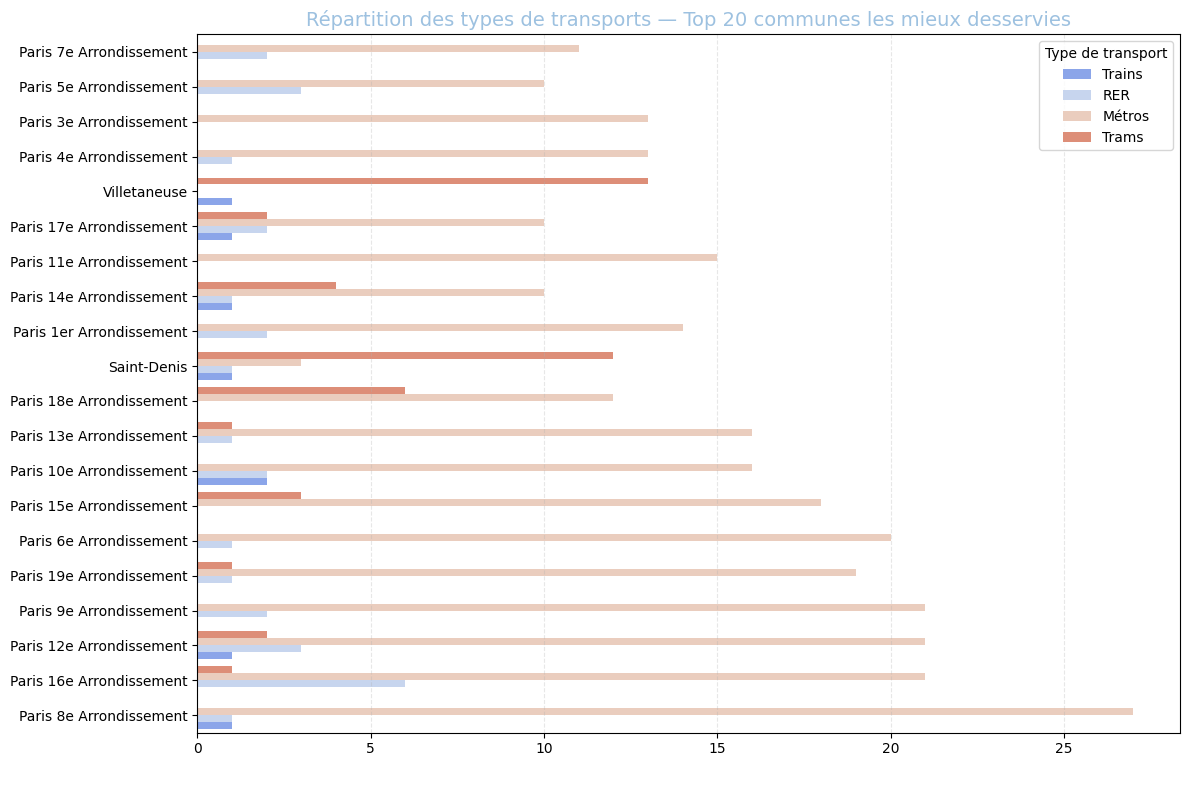

In [7]:
def afficher_top20_transports(dvf_df, transports_gdf):
    """
    Affiche le Top 20 des communes les mieux desservies en transports en commun.
    Fonction autonome : pas besoin d'appeler afficher_widget_transports().
    """

    # === 1. Préparation des communes (positions moyennes) ===
    communes_gdf = (
        dvf_df.groupby(["code_commune", "nom_commune", "code_departement"], as_index=False)[["latitude", "longitude"]]
        .mean()
    )
    communes_gdf = gpd.GeoDataFrame(
        communes_gdf,
        geometry=gpd.points_from_xy(communes_gdf["longitude"], communes_gdf["latitude"]),
        crs="EPSG:4326"
    )

    # === 2. Harmonisation et association transports ↔ communes les plus proches ===
    transports_gdf = transports_gdf.to_crs(epsg=4326)
    communes_m = communes_gdf.to_crs(epsg=2154)
    transports_m = transports_gdf.to_crs(epsg=2154)

    transports_proches = gpd.sjoin_nearest(
        transports_m,
        communes_m[["code_commune", "nom_commune", "code_departement", "geometry"]],
        how="left",
        distance_col="distance_m"
    ).to_crs(epsg=4326)

    # === 3. Regroupement par type et commune ===
    table_transports = (
        transports_proches.groupby(["code_departement", "code_commune", "nom_commune", "type"])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )

    # Conversion et total
    for col in table_transports.columns:
        if col not in ["code_departement", "code_commune", "nom_commune"]:
            table_transports[col] = table_transports[col].astype(int)
    table_transports["Total"] = table_transports.drop(columns=["code_departement", "code_commune", "nom_commune"]).sum(axis=1)

    # Fusion
    final_df = communes_gdf.merge(
        table_transports, on=["code_departement", "code_commune", "nom_commune"], how="left"
    ).fillna(0)

    # === 4. Calcul du Top 20 ===
    top20_df = (
        final_df[["nom_commune", "code_departement", "TRAIN", "RER", "METRO", "TRAM", "Total"]]
        .sort_values("Total", ascending=False)
        .head(20)
        .reset_index(drop=True)
    )

    top20_df.columns = ["Commune", "Département", "Trains", "RER", "Métros", "Trams", "Total transports"]

    # === 5. Affichage du tableau stylisé ===
    display(HTML("<h2 style='color:white; font-family:Segoe UI;'>🚉 Top 20 des communes les mieux desservies — Île-de-France</h2>"))
    display(
        top20_df.style.format(precision=0)
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', '#6C8AA5'),
                ('color', 'white'),
                ('font-weight', 'bold'),
                ('text-align', 'center')
            ]},
            {'selector': 'td', 'props': [('text-align', 'center')]}
        ])
        .hide(axis="index")
    )

    # === 6. Graphique de répartition ===
    top20_melt = top20_df.melt(
        id_vars=["Commune"],
        value_vars=["Trains", "RER", "Métros", "Trams"],
        var_name="Type de transport",
        value_name="Nombre"
    )

    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=top20_melt,
        x="Nombre",
        y="Commune",
        hue="Type de transport",
        palette="coolwarm"
    )

    plt.title("Répartition des types de transports — Top 20 communes les mieux desservies", fontsize=14, color="#9dc1e0")
    plt.xlabel("Nombre de transports", fontsize=12, color="white")
    plt.ylabel("")
    plt.legend(title="Type de transport")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

afficher_top20_transports(dvf_df, transports_gdf)



### Widget 7 : Vérifier la sécurité et l’attractivité du quartier

### Widget 8: Trouver des biens accessibles avec son budget (par département, par commune)

In [8]:
def afficher_widget_budget(dvf_df, communes_gdf):
    """
    Affiche un widget interactif permettant de visualiser la valeur foncière moyenne
    par commune en Île-de-France selon un budget sélectionné avec un slider.
    """
    # === 1. Préparation des données ===
    dvf_df["valeur_fonciere"] = pd.to_numeric(dvf_df["valeur_fonciere"], errors="coerce")
    dvf_df["code_commune"] = dvf_df["code_commune"].astype(str)
    communes_gdf["INSEE_COM"] = communes_gdf["INSEE_COM"].astype(str)

    moyennes_df = (
        dvf_df.groupby(["code_commune", "nom_commune"], as_index=False)["valeur_fonciere"]
        .mean()
        .rename(columns={"valeur_fonciere": "valeur_fonciere_moyenne"})
    )

    # Fusion sur les codes INSEE
    communes_valeurs = communes_gdf.merge(
        moyennes_df, left_on="INSEE_COM", right_on="code_commune", how="inner"
    )

    # === 2. Palette dynamique ===
    min_val = communes_valeurs["valeur_fonciere_moyenne"].min()
    max_val = communes_valeurs["valeur_fonciere_moyenne"].max()
    colormap = cm.linear.YlOrRd_09.scale(min_val, max_val)
    colormap.caption = "Valeur foncière moyenne (€)"

    # === 3. Fonction d’affichage de la carte ===
    def afficher_carte_range(budget_range):
        budget_min, budget_max = budget_range
        clear_output(wait=True)

        communes_filtrees = communes_valeurs[
            (communes_valeurs["valeur_fonciere_moyenne"] >= budget_min)
            & (communes_valeurs["valeur_fonciere_moyenne"] <= budget_max)
        ]

        m = folium.Map(location=[48.8566, 2.3522], zoom_start=9, tiles="CartoDB positron")
        cluster = MarkerCluster(name=f"Entre {budget_min:,.0f} € et {budget_max:,.0f} €").add_to(m)

        for _, row in communes_filtrees.iterrows():
            valeur = row["valeur_fonciere_moyenne"]
            commune = row["nom_commune"]
            coords = (row.geometry.y, row.geometry.x)
            color = colormap(valeur)

            popup = f"""
            <div style='font-family: Arial; font-size: 13px; line-height: 1.5;
                        border-radius: 10px; padding: 10px 15px;
                        background-color: rgba(255,255,255,0.95);
                        box-shadow: 0 2px 8px rgba(0,0,0,0.2);
                        text-align: center;'>
                <h4 style='margin:0; color:{color}; font-size:15px;'>🏙️ <b>{commune}</b></h4>
                <hr style='border:none; border-top:1px solid #ddd; margin:6px 0;'>
                <p style='margin:3px 0;'>
                    💰 <b>Valeur foncière moyenne :</b><br>
                    <span style='color:{color}; font-weight:bold; font-size:14px;'>{valeur:,.0f} €</span>
                </p>
            </div>
            """
            folium.CircleMarker(
                location=coords,
                radius=5,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.8,
                popup=popup
            ).add_to(cluster)

        colormap.add_to(m)
        display(m)

    # === 4. Slider interactif ===
    range_slider = widgets.IntRangeSlider(
        value=(int(min_val), int(max_val/2)),
        min=int(min_val),
        max=int(max_val),
        step=50000,
        description='📊 Budget (min - max)',
        continuous_update=False,
        layout=widgets.Layout(width="75%"),
        style={'description_width': 'initial'}
    )

    out = widgets.interactive_output(afficher_carte_range, {'budget_range': range_slider})

    # === 5. Style et affichage ===
    style_html = """
    <style>
    .output_subarea {
        color: #FFFFFF !important;
        font-family: 'Segoe UI', sans-serif;
        font-size: 14px;
    }
    .widget-inline-hbox {
        background-color: #6C8AA5 !important;
        border-radius: 12px;
        padding: 10px 20px;
        box-shadow: 0 2px 6px rgba(0,0,0,0.6);
    }
    </style>
    """

    display(HTML(style_html))
    display(range_slider, out)


afficher_widget_budget(dvf_df, communes_gdf)




IntRangeSlider(value=(60000, 715000), continuous_update=False, description='📊 Budget (min - max)', layout=Layo…

Output()

## TOP 20 

In [9]:


def afficher_widget_top20(dvf_df,communes_gdf):
    """
    Affiche un widget interactif pour visualiser le Top 20 des communes
    selon une plage de budget foncier choisie.
    """

    # === 1. Préparation des données ===
    dvf_df["valeur_fonciere"] = pd.to_numeric(dvf_df["valeur_fonciere"], errors="coerce")
    dvf_df["code_commune"] = dvf_df["code_commune"].astype(str)
    communes_gdf["INSEE_COM"] = communes_gdf["INSEE_COM"].astype(str)

    moyennes_df = (
        dvf_df.groupby(["code_commune", "nom_commune"], as_index=False)["valeur_fonciere"]
        .mean()
        .rename(columns={"valeur_fonciere": "valeur_fonciere_moyenne"})
    )

    communes_valeurs = communes_gdf.merge(
        moyennes_df, left_on="INSEE_COM", right_on="code_commune", how="inner"
    )

    # === 1. Création du widget de sortie pour le tableau ===
    output_top20 = widgets.Output()

    # === 2. Widgets pour les bornes ===
    budget_min_widget = widgets.BoundedIntText(
        value=int(communes_valeurs["valeur_fonciere_moyenne"].min()),
        min=0,
        max=int(communes_valeurs["valeur_fonciere_moyenne"].max()),
        step=50000,
        description='💶 Budget min :',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width="250px")
    )

    budget_max_widget = widgets.BoundedIntText(
        value=int(communes_valeurs["valeur_fonciere_moyenne"].max() / 2),
        min=0,
        max=int(communes_valeurs["valeur_fonciere_moyenne"].max()),
        step=50000,
        description='💶 Budget max :',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width="250px")
    )

    # === 3. Fonction de mise à jour du Top 20 ===
    def afficher_top20_v2(budget_min, budget_max):
        communes_filtrees = communes_valeurs[
            (communes_valeurs["valeur_fonciere_moyenne"] >= budget_min)
            & (communes_valeurs["valeur_fonciere_moyenne"] <= budget_max)
        ]

        top20 = communes_filtrees.sort_values("valeur_fonciere_moyenne", ascending=True).head(20)

        output_top20.clear_output()
        with output_top20:
            if top20.empty:
                display(HTML(f"""
                <p style='color:#ff6b6b; font-family:Segoe UI;'>
                    ⚠️ Aucune commune ne correspond à cette plage.
                </p>
                """))
            else:
                display(HTML(f"""
                <h3 style='color:#9dc1e0; font-family:Segoe UI; margin-bottom:10px;'>
                    🏙️ Top 20 des communes pour un budget entre {budget_min:,.0f} € et {budget_max:,.0f} €
                </h3>
                """))
                display(
                    top20[["nom_commune", "valeur_fonciere_moyenne"]]
                    .rename(columns={
                        "nom_commune": "Commune",
                        "valeur_fonciere_moyenne": "Valeur foncière moyenne (€)"
                    })
                    .style.format({"Valeur foncière moyenne (€)": "{:,.0f} €"})
                    .set_table_styles([
                        {'selector': 'th', 'props': [
                            ('background-color', '#6C8AA5'),
                            ('color', 'white'),
                            ('font-weight', 'bold'),
                            ('text-align', 'center')
                        ]},
                        {'selector': 'td', 'props': [('text-align', 'center')]}
                    ])
                    .hide(axis="index")
                )

    # === 4. Liaison interactive ===
    widgets.interactive_output(
        afficher_top20_v2,
        {'budget_min': budget_min_widget, 'budget_max': budget_max_widget}
    )

    # === 5. Affichage final ===
    display(HTML("""
    <h2 style='color:white; font-family:Segoe UI;'>🏙️ Top 20 des communes selon ton budget</h2>
    <p style='color:#cccccc; font-family:Segoe UI;'>
    Ce tableau se met automatiquement à jour quand tu modifies le budget minimum ou maximum.
    </p>
    """))

    # Conteneur des widgets
    box_budgets = widgets.HBox([budget_min_widget, budget_max_widget])
    box_budgets.add_class("budget-box")

    display(box_budgets)
    display(output_top20)

    # === 6. Style visuel ===
    display(HTML("""
    <style>
    .budget-box {
        display: flex !important;
        justify-content: center !important;
        align-items: center !important;
        background: rgba(108, 138, 165, 0.3);
        border-radius: 12px;
        padding: 10px 20px;
        gap: 20px;
        box-shadow: 0 3px 8px rgba(0,0,0,0.3);
        margin-bottom: 15px;
    }
    .output_subarea {
        color: white !important;
        font-family: Segoe UI, sans-serif !important;
    }
    table.dataframe, th, td {
        border: 1px solid #444 !important;
    }
    </style>
    """))

afficher_widget_top20(dvf_df, communes_gdf)

Output()

### Widget 9 : Obtenir un classement des Top 10 opportunités actuelles (un tableau ou score automatique)

In [ ]:
def calculate_coloc_advantage(df_rendement):
    """
    Calculate colocation advantage for each commune by comparing yields between property types
    
    The idea: In some communes, renting large properties (T3+, Maison) as coloc 
    can be more profitable than renting small units (T1-T2)
    """
    
    # Get average metrics by commune (not by type)
    commune_avg = df_rendement.groupby(['code_commune', 'nom_commune']).agg({
        'loyer_predit_m2': 'mean',
        'prix_m2': 'mean'
    }).reset_index()
    
    # Get metrics by commune and type
    commune_types = df_rendement.groupby(['code_commune', 'nom_commune', 'type_local']).agg({
        'rendement_brut': 'mean',
        'prix_m2': 'mean',
        'loyer_predit_m2': 'mean'
    }).reset_index()
    
    # For each property type in each commune, calculate coloc advantage
    result = []
    
    for commune in commune_types['code_commune'].unique():
        commune_data = commune_types[commune_types['code_commune'] == commune]
        commune_name = commune_data['nom_commune'].iloc[0]
        
        # Get T1-T2 loyer if exists
        t1_t2_data = commune_data[commune_data['type_local'] == 'Appartement T1-T2']
        t1_t2_loyer = t1_t2_data['loyer_predit_m2'].iloc[0] if len(t1_t2_data) > 0 else None
        
        # Calculate advantage for each type
        for _, row in commune_data.iterrows():
            type_local = row['type_local']
            
            if type_local in ['Appartement T3+', 'Maison'] and t1_t2_loyer is not None:
                # Large property can benefit from coloc if T1-T2 loyer is higher
                loyer_diff = t1_t2_loyer - row['loyer_predit_m2']
                advantage = max(0, loyer_diff * 10)  # Scale up
            else:
                advantage = 0
            
            result.append({
                'code_commune': commune,
                'nom_commune': commune_name,
                'type_local': type_local,
                'coloc_advantage_raw': advantage
            })
    
    result_df = pd.DataFrame(result)
    
    # Normalize to 0-100 scale
    if result_df['coloc_advantage_raw'].max() > 0:
        result_df['coloc_advantage_score'] = (
            result_df['coloc_advantage_raw'] / result_df['coloc_advantage_raw'].max() * 100
        )
    else:
        result_df['coloc_advantage_score'] = 0
    
    return result_df[['code_commune', 'nom_commune', 'type_local', 'coloc_advantage_score']]


def calculate_master_opportunity_score(df_rendement, df_liquidite=None, df_transport=None, 
                                       df_services=None, df_security=None,
                                       max_budget=None, weights=None, verbose=True):
    """
    Calculate comprehensive investment opportunity score
    
    Parameters:
    -----------
    df_rendement : DataFrame
        DataFrame with rendement_brut, prix_m2, nombre_mutations, etc. (REQUIRED)
    df_liquidite : DataFrame, optional
        DataFrame with score_liquidite_2024 (0-100). If None, liquidité not included.
    df_transport : DataFrame, optional
        DataFrame with transport_count or transport_score per commune
    df_services : DataFrame, optional
        DataFrame with services_count or services_score per commune
    df_security : DataFrame, optional
        DataFrame with security_score per commune
    max_budget : float, optional
        Maximum budget in euros
    weights : dict, optional
        Custom weights for each factor. Only factors with data will be used.
    verbose : bool, optional
        If True, print detailed logging of score calculation
    
    Returns:
    --------
    DataFrame with opportunity scores and rankings
    """
    
    if verbose:
        print("\n" + "="*80)
        print("🎯 CALCUL DU SCORE D'OPPORTUNITÉ D'INVESTISSEMENT")
        print("="*80 + "\n")
    
    # Determine available factors
    available_factors = ['rendement', 'coloc', 'budget']  # Always available from df_rendement
    
    if df_liquidite is not None:
        available_factors.append('liquidite')
    if df_transport is not None:
        available_factors.append('transport')
    if df_services is not None:
        available_factors.append('services')
    if df_security is not None:
        available_factors.append('security')
    
    if verbose:
        print(f"📊 Facteurs disponibles: {', '.join(available_factors)}")
        print(f"   Total: {len(available_factors)} facteurs\n")
    
    # Default weights based on available factors
    if weights is None:
        n_factors = len(available_factors)
        
        if n_factors == 3:  # Only rendement, coloc, budget
            weights = {
                'rendement': 0.60,
                'coloc': 0.25,
                'budget': 0.15
            }
        elif n_factors == 4:  # + liquidite
            weights = {
                'rendement': 0.40,
                'liquidite': 0.35,
                'coloc': 0.15,
                'budget': 0.10
            }
        elif n_factors == 5:  # + transport or services
            weights = {
                'rendement': 0.35,
                'liquidite': 0.30 if 'liquidite' in available_factors else 0,
                'coloc': 0.15,
                'budget': 0.10,
                'transport': 0.10 if 'transport' in available_factors else 0,
                'services': 0.10 if 'services' in available_factors else 0
            }
        elif n_factors == 6:
            weights = {
                'rendement': 0.30,
                'liquidite': 0.25 if 'liquidite' in available_factors else 0,
                'coloc': 0.15,
                'budget': 0.10,
                'transport': 0.10 if 'transport' in available_factors else 0,
                'services': 0.10 if 'services' in available_factors else 0,
                'security': 0.10 if 'security' in available_factors else 0
            }
        else:  # All factors (7)
            weights = {
                'rendement': 0.25,
                'liquidite': 0.25,
                'coloc': 0.15,
                'budget': 0.10,
                'transport': 0.10,
                'services': 0.10,
                'security': 0.05
            }
    
    # --- START WITH RENDEMENT DATA ---
    df_score = df_rendement.copy()
    
    if verbose:
        print(f"📈 Données de départ: {len(df_score)} lignes (commune × type de bien)")
        print(f"   Communes uniques: {df_score['code_commune'].nunique()}")
        print(f"   Types de biens: {df_score['type_local'].unique().tolist()}\n")
    
    # --- 1. NORMALIZE RENDEMENT TO 0-100 ---
    if verbose:
        print("1️⃣  Normalisation du rendement brut...")
    
    rend_min = df_score['rendement_brut'].min()
    rend_max = df_score['rendement_brut'].max()
    df_score['score_rendement'] = ((df_score['rendement_brut'] - rend_min) / 
                                    (rend_max - rend_min) * 100)
    
    if verbose:
        print(f"   Range: {rend_min:.2f}% → {rend_max:.2f}%")
        print(f"   Score moyen: {df_score['score_rendement'].mean():.1f}/100\n")
    
    # --- 2. MERGE LIQUIDITÉ (if available) ---
    if df_liquidite is not None:
        if verbose:
            print("2️⃣  Fusion des scores de liquidité...")
        
        df_score = df_score.merge(
            df_liquidite[['code_commune', 'score_liquidite_2024']], 
            on='code_commune', 
            how='left'
        )
        df_score['score_liquidite'] = df_score['score_liquidite_2024'].fillna(0)
        
        if verbose:
            matched = (df_score['score_liquidite'] > 0).sum()
            print(f"   Communes avec données de liquidité: {matched}/{len(df_score)}")
            print(f"   Score moyen: {df_score['score_liquidite'].mean():.1f}/100\n")
    else:
        df_score['score_liquidite'] = 0
        weights['liquidite'] = 0
        if verbose:
            print("2️⃣  Liquidité: Pas de données disponibles (score = 0)\n")
    
    # --- 3. CALCULATE COLOC ADVANTAGE ---
    if verbose:
        print("3️⃣  Calcul du potentiel colocation...")
    
    coloc_scores = calculate_coloc_advantage(df_rendement)
    df_score = df_score.merge(
        coloc_scores[['code_commune', 'type_local', 'coloc_advantage_score']], 
        on=['code_commune', 'type_local'], 
        how='left'
    )
    df_score['score_coloc'] = df_score['coloc_advantage_score'].fillna(0)
    
    if verbose:
        has_coloc = (df_score['score_coloc'] > 0).sum()
        print(f"   Propriétés avec potentiel coloc: {has_coloc}/{len(df_score)}")
        print(f"   Score moyen: {df_score['score_coloc'].mean():.1f}/100\n")
    
    # --- 4. BUDGET ACCESSIBILITY SCORE ---
    if verbose:
        print("4️⃣  Calcul de l'accessibilité budgétaire...")
    
    if max_budget is not None:
        # Estimate property price
        df_score['estimated_price'] = df_score.apply(
            lambda row: row['prix_m2'] * (80 if row['type_local'] == 'Maison' else 50),
            axis=1
        )
        
        # Score: 100 if within budget, decreasing as price increases
        df_score['score_budget'] = np.where(
            df_score['estimated_price'] <= max_budget,
            100,
            np.maximum(0, 100 - ((df_score['estimated_price'] - max_budget) / max_budget * 100))
        )
        
        df_score['within_budget'] = df_score['estimated_price'] <= max_budget
        
        if verbose:
            within = df_score['within_budget'].sum()
            print(f"   Budget maximum: {max_budget:,.0f} €")
            print(f"   Biens dans le budget: {within}/{len(df_score)}")
            print(f"   Score moyen: {df_score['score_budget'].mean():.1f}/100\n")
    else:
        # Use inverse price normalization
        price_min = df_score['prix_m2'].min()
        price_max = df_score['prix_m2'].max()
        df_score['score_budget'] = ((price_max - df_score['prix_m2']) / 
                                     (price_max - price_min) * 100)
        df_score['within_budget'] = True
        
        if verbose:
            print(f"   Pas de budget spécifié - normalisation par prix")
            print(f"   Range prix/m²: {price_min:.0f}€ → {price_max:.0f}€")
            print(f"   Score moyen: {df_score['score_budget'].mean():.1f}/100\n")
    
    # --- 5. TRANSPORT SCORE (if available) ---
    if df_transport is not None:
        if verbose:
            print("5️⃣  Fusion des données de transport...")
        
        df_score = df_score.merge(
            df_transport[['code_commune', 'transport_score' if 'transport_score' in df_transport.columns else 'transport_count']], 
            on='code_commune', 
            how='left'
        )
        
        if 'transport_count' in df_score.columns and 'transport_score' not in df_score.columns:
            trans_min = df_score['transport_count'].min()
            trans_max = df_score['transport_count'].max()
            if trans_max > trans_min:
                df_score['score_transport'] = ((df_score['transport_count'] - trans_min) / 
                                                (trans_max - trans_min) * 100)
            else:
                df_score['score_transport'] = 50
            
            if verbose:
                print(f"   Normalisation du nombre de transports ({trans_min:.0f} → {trans_max:.0f})")
        else:
            df_score['score_transport'] = df_score.get('transport_score', 0)
        
        df_score['score_transport'] = df_score['score_transport'].fillna(0)
        
        if verbose:
            print(f"   Score moyen: {df_score['score_transport'].mean():.1f}/100\n")
    else:
        df_score['score_transport'] = 0
        weights['transport'] = 0
        if verbose:
            print("5️⃣  Transport: Pas de données disponibles (score = 0)\n")
    
    # --- 6. SERVICES SCORE (if available) ---
    if df_services is not None:
        if verbose:
            print("6️⃣  Fusion des données de services...")
        
        df_score = df_score.merge(
            df_services[['code_commune', 'services_score' if 'services_score' in df_services.columns else 'services_count']], 
            on='code_commune', 
            how='left'
        )
        
        if 'services_count' in df_score.columns and 'services_score' not in df_score.columns:
            serv_min = df_score['services_count'].min()
            serv_max = df_score['services_count'].max()
            if serv_max > serv_min:
                df_score['score_services'] = ((df_score['services_count'] - serv_min) / 
                                               (serv_max - serv_min) * 100)
            else:
                df_score['score_services'] = 50
            
            if verbose:
                print(f"   Normalisation du nombre de services ({serv_min:.0f} → {serv_max:.0f})")
        else:
            df_score['score_services'] = df_score.get('services_score', 0)
        
        df_score['score_services'] = df_score['score_services'].fillna(0)
        
        if verbose:
            print(f"   Score moyen: {df_score['score_services'].mean():.1f}/100\n")
    else:
        df_score['score_services'] = 0
        weights['services'] = 0
        if verbose:
            print("6️⃣  Services: Pas de données disponibles (score = 0)\n")
    
    # --- 7. SECURITY SCORE (if available) ---
    if df_security is not None:
        if verbose:
            print("7️⃣  Fusion des données de sécurité...")
        
        df_score = df_score.merge(
            df_security[['code_commune', 'security_score']], 
            on='code_commune', 
            how='left'
        )
        df_score['score_security'] = df_score['security_score'].fillna(0)
        
        if verbose:
            print(f"   Score moyen: {df_score['score_security'].mean():.1f}/100\n")
    else:
        df_score['score_security'] = 0
        weights['security'] = 0
        if verbose:
            print("7️⃣  Sécurité: Pas de données disponibles (score = 0)\n")
    
    # --- RENORMALIZE WEIGHTS ---
    total_weight = sum(weights.values())
    if total_weight > 0:
        weights_norm = {k: v/total_weight for k, v in weights.items()}
    else:
        weights_norm = {'rendement': 1.0}
    
    if verbose:
        print("⚖️  Pondérations finales:")
        for factor, weight in weights_norm.items():
            if weight > 0:
                print(f"   • {factor.capitalize()}: {weight*100:.1f}%")
        print()
    
    # --- CALCULATE MASTER SCORE ---
    if verbose:
        print("🎲 Calcul du score global...")
    
    df_score['opportunity_score'] = (
        weights_norm.get('rendement', 0) * df_score['score_rendement'] +
        weights_norm.get('liquidite', 0) * df_score['score_liquidite'] +
        weights_norm.get('coloc', 0) * df_score['score_coloc'] +
        weights_norm.get('budget', 0) * df_score['score_budget'] +
        weights_norm.get('transport', 0) * df_score['score_transport'] +
        weights_norm.get('services', 0) * df_score['score_services'] +
        weights_norm.get('security', 0) * df_score['score_security']
    )
    
    if verbose:
        print(f"   Score moyen: {df_score['opportunity_score'].mean():.1f}/100")
        print(f"   Score min: {df_score['opportunity_score'].min():.1f}/100")
        print(f"   Score max: {df_score['opportunity_score'].max():.1f}/100\n")
    
    # --- RANK ---
    df_score['rank'] = df_score['opportunity_score'].rank(ascending=False, method='dense').astype(int)
    
    # --- RATING ---
    df_score['rating'] = pd.cut(
        df_score['opportunity_score'],
        bins=[0, 40, 50, 60, 70, 80, 90, 100],
        labels=['D', 'C', 'C+', 'B', 'B+', 'A', 'A+'],
        include_lowest=True
    )
    
    if verbose:
        print("🏆 Classement terminé!")
        rating_counts = df_score['rating'].value_counts().sort_index(ascending=False)
        print("   Distribution des notes:")
        for rating, count in rating_counts.items():
            print(f"   • {rating}: {count} biens ({count/len(df_score)*100:.1f}%)")
        print("\n" + "="*80 + "\n")
    
    # Sort by rank
    df_score = df_score.sort_values('rank')
    
    return df_score


def plot_top_opportunities(df_top, title="Top Opportunités d'Investissement"):
    """
    Create visualization for top investment opportunities
    
    Parameters:
    -----------
    df_top : DataFrame
        DataFrame with top opportunities (output of get_top_opportunities)
    title : str
        Plot title
    """
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # Colors
    colors = {
        'primary': '#222E6F',
        'secondary': '#B29FD3',
        'accent': '#FFB266',
        'success': '#4CAF50'
    }
    
    # --- 1. Horizontal Bar Chart: Overall Score ---
    ax1 = fig.add_subplot(gs[0, :])
    
    # Prepare data (reverse for top-to-bottom display)
    plot_data = df_top.iloc[::-1].copy()
    y_pos = range(len(plot_data))
    
    # Create labels with commune and type
    labels = [f"{row['Commune']} ({row['Dép.']}) - {row['Type']}" 
              for _, row in plot_data.iterrows()]
    
    # Color gradient based on score
    norm = plt.Normalize(vmin=plot_data['Score Global'].min(), 
                        vmax=plot_data['Score Global'].max())
    bar_colors = plt.cm.RdYlGn(norm(plot_data['Score Global']))
    
    bars = ax1.barh(y_pos, plot_data['Score Global'], 
                    color=bar_colors, edgecolor='white', linewidth=2, alpha=0.9)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels, fontsize=10, fontweight='600')
    ax1.set_xlabel('Score Global (/100)', fontsize=12, fontweight='bold', color='#333')
    ax1.set_title('Score Global d\'Opportunité', 
                  fontsize=14, fontweight='bold', pad=20, color=colors['primary'])
    ax1.set_xlim(0, 100)
    
    # Add score labels
    for i, (bar, value, rating) in enumerate(zip(bars, plot_data['Score Global'], plot_data['Note'])):
        ax1.text(value + 2, bar.get_y() + bar.get_height()/2,
                f'{value:.1f} ({rating})',
                ha='left', va='center', fontsize=9, fontweight='bold', color='#333')
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(axis='x', alpha=0.2, linestyle='--')
    
    # --- 2. Radar Chart: Score Breakdown (for #1) ---
    ax2 = fig.add_subplot(gs[1, 0], projection='polar')
    
    # Get top 1
    top_1 = df_top.iloc[0]
    
    # Prepare categories and values
    categories = []
    values = []
    
    score_cols = {
        'Rendement (%)': 'Rendement',
        'Liquidité': 'Liquidité',
        'Potentiel Coloc': 'Coloc',
        'Transport': 'Transport',
        'Services': 'Services',
        'Sécurité': 'Sécurité'
    }
    
    for col, label in score_cols.items():
        if col in df_top.columns and not pd.isna(top_1.get(col, np.nan)):
            categories.append(label)
            # Normalize rendement to 0-100 scale
            if col == 'Rendement (%)':
                val = (top_1[col] / df_top['Rendement (%)'].max()) * 100
            else:
                val = top_1[col]
            values.append(val)
    
    if len(categories) > 0:
        # Number of variables
        num_vars = len(categories)
        
        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        
        # Complete the circle
        values += values[:1]
        angles += angles[:1]
        
        # Plot
        ax2.plot(angles, values, 'o-', linewidth=2, color=colors['primary'])
        ax2.fill(angles, values, alpha=0.25, color=colors['primary'])
        ax2.set_xticks(angles[:-1])
        ax2.set_xticklabels(categories, fontsize=10)
        ax2.set_ylim(0, 100)
        ax2.set_yticks([25, 50, 75, 100])
        ax2.set_yticklabels(['25', '50', '75', '100'], fontsize=8, color='gray')
        ax2.grid(True, alpha=0.3)
        
        commune_label = f"{top_1['Commune']} - {top_1['Type']}"
        ax2.set_title(f'Détail du #1: {commune_label}', 
                     fontsize=12, fontweight='bold', pad=20, color=colors['primary'])
    
    # --- 3. Scatter Plot: Rendement vs Prix ---
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Create scatter
    scatter = ax3.scatter(df_top['Prix/m²'], df_top['Rendement (%)'],
                         s=df_top['Score Global']*5,  # Size by score
                         c=df_top['Score Global'],    # Color by score
                         cmap='RdYlGn',
                         alpha=0.7,
                         edgecolors='white',
                         linewidth=2)
    
    # Add labels for top 3
    for idx in range(min(3, len(df_top))):
        row = df_top.iloc[idx]
        ax3.annotate(f"#{idx+1}", 
                    xy=(row['Prix/m²'], row['Rendement (%)']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=colors['accent'], alpha=0.7))
    
    ax3.set_xlabel('Prix d\'achat (€/m²)', fontsize=11, fontweight='bold', color='#333')
    ax3.set_ylabel('Rendement brut (%)', fontsize=11, fontweight='bold', color='#333')
    ax3.set_title('Rendement vs Prix d\'Achat', 
                  fontsize=12, fontweight='bold', pad=15, color=colors['primary'])
    ax3.grid(True, alpha=0.2, linestyle='--')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Score Global', fontsize=10, fontweight='bold')
    
    # Overall title
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()


def get_top_opportunities(df_score, n=10, min_transactions=10, budget_only=False, plot=True):
    """
    Get top N investment opportunities
    
    Parameters:
    -----------
    df_score : DataFrame
        DataFrame with opportunity scores
    n : int
        Number of top opportunities
    min_transactions : int
        Minimum transactions for reliability
    budget_only : bool
        If True, only show properties within budget
    plot : bool
        If True, display visualization
    
    Returns:
    --------
    DataFrame with top N opportunities
    """
    # Filter
    df_filtered = df_score.copy()
    
    if 'nombre_mutations' in df_filtered.columns:
        df_filtered = df_filtered[df_filtered['nombre_mutations'] >= min_transactions]
    
    if budget_only and 'within_budget' in df_filtered.columns:
        df_filtered = df_filtered[df_filtered['within_budget']]
    
    # Get top N
    top_n = df_filtered.nsmallest(n, 'rank')
    
    # Select columns
    base_cols = ['rank', 'nom_commune', 'DEP', 'type_local', 'opportunity_score', 'rating',
                 'rendement_brut', 'score_liquidite', 'score_coloc', 'prix_m2']
    
    if 'nombre_mutations' in top_n.columns:
        base_cols.append('nombre_mutations')
    
    optional_cols = ['score_transport', 'score_services', 'score_security', 'estimated_price']
    
    display_cols = [col for col in base_cols if col in top_n.columns]
    display_cols += [col for col in optional_cols if col in top_n.columns]
    
    result = top_n[display_cols].copy()
    
    # Rename
    rename_dict = {
        'nom_commune': 'Commune',
        'DEP': 'Dép.',
        'type_local': 'Type',
        'opportunity_score': 'Score Global',
        'rating': 'Note',
        'rendement_brut': 'Rendement (%)',
        'score_liquidite': 'Liquidité',
        'score_coloc': 'Potentiel Coloc',
        'score_transport': 'Transport',
        'score_services': 'Services',
        'score_security': 'Sécurité',
        'prix_m2': 'Prix/m²',
        'estimated_price': 'Prix estimé',
        'nombre_mutations': 'Transactions'
    }
    
    result = result.rename(columns=rename_dict)
    
    # Format
    format_cols = {
        'Rendement (%)': 2,
        'Score Global': 1,
        'Liquidité': 1,
        'Potentiel Coloc': 1,
        'Transport': 1,
        'Services': 1,
        'Sécurité': 1
    }
    
    for col, decimals in format_cols.items():
        if col in result.columns:
            result[col] = result[col].round(decimals)
    
    if 'Prix/m²' in result.columns:
        result['Prix/m²'] = result['Prix/m²'].round(0).astype(int)
    
    if 'Prix estimé' in result.columns:
        result['Prix estimé'] = result['Prix estimé'].round(0).astype(int)
    
    if 'Transactions' in result.columns:
        result['Transactions'] = result['Transactions'].astype(int)
    
    result = result.reset_index(drop=True)
    
    # Plot if requested
    if plot:
        plot_top_opportunities(result)
    
    return result


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# Calculate scores with verbose logging
df_scored = calculate_master_opportunity_score(
    df_rendement_brut,
    verbose=True  # Show detailed logging
)

# Get top 10 with plot
top_10 = get_top_opportunities(
    df_scored, 
    n=10, 
    min_transactions=10,
    plot=True  # Display visualization
)

# Display table
print("\n🏆 TOP 10 OPPORTUNITÉS D'INVESTISSEMENT")
print("="*100)
display(top_10)